### This code allow to manipulate the datas of all the sessions and the mice at the same time for analytic or statistic purpose. Some tools to help the user do these are also present

indicate the path to the folder where the data of your mice are in folder_path, then indicate which mice must be analyzed in list_mouse_number. Running this first cell will take a few minutes and it is better to indicate all to mice you wish to work with and only needing to run this cell once

In [1]:
# Cell 1 : analyse all the sessions of the choosen mouses and agregate their data

#get all the sessions and their parameter
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from own_Functions import *
from scipy.ndimage import gaussian_filter as smooth
import scipy.stats as stats
import matplotlib.patches as mpatches

#problems remaining : how to treat the missing values in turnsinfo ?
#                     I don't have the phase of the session


list_mouse_number = ["MOU3975", "MOU3987", "MOU3988", "MOU3991", "MOU3992", "MOU4087", "MOU4088"]
folder_path = "/localdata/alicedata/"
MetaData = pd.DataFrame({}) ; size_off_data = 0 #dataframe which will contain every infos of TXY
Meta_turn = pd.DataFrame({}) ; size_off_turns = 0 #dataframe which will contain every info of turnsinfo


#intialize the value of some variable
#define some important global variable
MINIMAL_DURATION_STOP = 0.1 #if a stop is shorter than this, fusionne the two epochs bordering it
MINIMAL_DURATION_EPOCH = 0.3 #minimal duration of an epoch to be considerd
TRAPEZE_SIZE = 35 # how much to extend outside of the objects to detect the trajectories
Resolution = 512,512 # variable which store the size of the experimental field in pixel
sigma_gauss  = 1 # the sigma used for the remaining of the analysis
true_cut_speed = 7 #value to be used for the remaining of the analysis
true_ecart_angle = 1 # if a change is made, must change timeofframes

#define the coordinate of the patches
NWpatch_coords = [[109, Resolution[1] -  130], [188, Resolution[1] -  130], [188, Resolution[1] -  215], [109, Resolution[1] -  215]]
NEpatch_coords = [[320, Resolution[1] -  130], [400, Resolution[1] -  130], [400, Resolution[1] -  210], [320, Resolution[1] -  210]]
SWpatch_coords = [[112, Resolution[1] -  344], [191, Resolution[1] -  344], [191, Resolution[1] -  410], [112, Resolution[1] -  410]]
SEpatch_coords = [[315, Resolution[1] -  350], [395, Resolution[1] -  350], [395, Resolution[1] -  415], [315, Resolution[1] -  415]]



#define the list of trapeze as a dictionnary containing  dictionnary to access them more easly
collection_trapeze = {"NW" : dict(), "NE" : dict(), "SW" : dict(), "SE" : dict()}
collection_trapeze["NW"]["N"], collection_trapeze["NW"]["E"], collection_trapeze["NW"]["S"], collection_trapeze["NW"]["W"] = trapezes_from_patch(NWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["NE"]["N"], collection_trapeze["NE"]["E"], collection_trapeze["NE"]["S"], collection_trapeze["NE"]["W"] = trapezes_from_patch(NEpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SW"]["N"], collection_trapeze["SW"]["E"], collection_trapeze["SW"]["S"], collection_trapeze["SW"]["W"] = trapezes_from_patch(SWpatch_coords, TRAPEZE_SIZE)
collection_trapeze["SE"]["N"], collection_trapeze["SE"]["E"], collection_trapeze["SE"]["S"], collection_trapeze["SE"]["W"] = trapezes_from_patch(SEpatch_coords, TRAPEZE_SIZE)


sessionFolders = {}
Meta_session_infos = {} #creat a dictionnary for each mouse
Meta_list_epoch = {}
for a in list_mouse_number : 
    Meta_session_infos[a] = pd.DataFrame({})
    Meta_list_epoch[a] = {}






#creation of the dataframes wich contain the infirmations for every session
for mouse in list_mouse_number : 
    session_to_remove = [] #store the index of the session that must not be consider because we are missing their csv files   
    mouseFolder_Path = folder_path + mouse
    os.chdir(mouseFolder_Path)
    sessionFolders[mouse]=[name for name in os.listdir(mouseFolder_Path) if os.path.isdir(os.path.join(mouseFolder_Path, name)) and name[0:3]=="MOU"]
    sessionFolders[mouse].sort()

    sessionParams = []
    for a in range(len(sessionFolders[mouse])) :
        session = sessionFolders[mouse][a]
        #get the TXY datas and clean it
        try : 
            df=pd.read_csv(mouseFolder_Path + "/" + session + "/" + session + "_centroidTXY.csv")# get the TXY file
            df=df.dropna() #supprime les lignes avec un ou plusieurs NA
            df=df.loc[df['time'] >15] # il y a des artefacts sur les premieres secondes de videos, donc il faut les supprimer
        except : 
            #if there was a bug in the session and the file of it were not created, don't consider the session for the analysis
            session_to_remove.append(a)
            continue
        df=df[df['xposition'].between(1,500) & df['yposition'].between(1,500)] #on garde les valeurs entre 15 et 500 (le tableau est cree plus grand que necessaire)

        df['xposition'] = smooth(df['xposition'].to_numpy(), sigma= sigma_gauss)#smooth the trajectory in x
        df['yposition'] = smooth(Resolution[1] - df['yposition'].to_numpy(), sigma= sigma_gauss) # smooth the trajectory in y and inverse the axis

        sizedf = len(df)
        df['session'] = [session] * sizedf #add column with the session to the dataframe
        #change the index of df to be compatible with metadata
        df['index'] = list(range(size_off_data, size_off_data + sizedf))
        df = df.set_index('index')

        MetaData = pd.concat([MetaData, df])#add the data of df at the end of metadata
        

        ######################################################

        #get the turnsinfo data
        dfturns = pd.read_csv(mouseFolder_Path + "/" + session + "/" + session + "_turnsinfo.csv")# get the TXY file
        dfturns=dfturns.loc[dfturns['time'] >15] # il y a des artefacts sur les premieres secondes de videos, donc il faut les supprimer

        sizedf_turn = len(dfturns)
        dfturns['session'] = [session] * sizedf_turn #add column with the session to the dataframe
        #change the index of df to be compatible with metadata
        dfturns['index'] = list(range(size_off_turns, size_off_turns + sizedf_turn))
        dfturns =  dfturns.set_index('index')

        Meta_turn = pd.concat([Meta_turn, dfturns])

        #####################################################

        session_infos = pd.read_csv(mouseFolder_Path + "/" + session + "/" + session + "_sessionparam.csv")

        #detect the type of phase
        try :
            if not session_infos.loc[session_infos.index[0], "Rewarded"] : phase = 0 #if no reward can be given, then it's the free exploration
            elif session_infos.loc[session_infos.index[0], "number_of_alternativeObject"] == 1 : phase = 4 #if only one alternative is available for the objects at a given time in the session, it's session 4 
            elif session_infos.loc[session_infos.index[0], "number_of_alternativeObject"] == 3 : phase = 3 #then it's phase 3
            elif session_infos.loc[session_infos.index[0], "potentialRewardedDirections"] == '[90, 270]' : phase = 1
            else : phase = 2
        except :
            phase = -1

        #add some informations to the session info. See below for details
        #session_infos += [phase, size_off_data, size_off_data + sizedf, size_off_turns, size_off_turns + sizedf_turn]
        session_infos["phase"] = [phase] ; session_infos["startPosition"] = [size_off_data] ; session_infos["endPosition"] = [size_off_data + sizedf]
        session_infos["startTurns"] = [size_off_turns] ; session_infos["endTurns"] = [size_off_turns + sizedf_turn]
        
        session_infos["timeOfDay"] = "M" # "M" for morning

        session_infos["session"] = session
        Meta_session_infos[mouse] = pd.concat([Meta_session_infos[mouse], session_infos])


        size_off_data += sizedf ; size_off_turns += sizedf_turn

    Meta_session_infos[mouse].set_index("session", inplace = True)

    distance = len(session_to_remove) - 1
    for i in range(distance, -1, -1) : 
        sessionFolders[mouse].pop(session_to_remove[i])#remove the unusable sessions in reverse order so that the indice does not move
    for a in range(1, len(sessionFolders[mouse])) :
        if sessionFolders[mouse][a-1][8:16] == sessionFolders[mouse][a][8:16] : #if the day of the session is the same as the previous session, it's the afternoon. every other case is considerd morning
            Meta_session_infos[mouse].loc[sessionFolders[mouse][a], "timeOfDay"] = "A" # "A" for afternoon




MetaData['distance'] = np.zeros(size_off_data)
MetaData['speed'] = np.zeros(size_off_data)
MetaData['timeAverage'] = np.zeros(size_off_data)
MetaData['acceleration'] = np.zeros(size_off_data)
MetaData['direction'] = np.zeros(size_off_data)
MetaData['angularSpeed'] = np.zeros(size_off_data)


for mouse in list_mouse_number :
    for session in Meta_session_infos[mouse].index :

        start_data = Meta_session_infos[mouse].loc[session, "startPosition"]#get the start and end indice for the session (on the metadata dataframe)
        end_data = Meta_session_infos[mouse].loc[session, "endPosition"]

        #this function does the analysis of the session then store the informations corresponding in Metadata + List_epoch
        MetaData.loc[MetaData.index[start_data: end_data], 'distance'], MetaData.loc[MetaData.index[start_data: end_data], 'speed'], MetaData.loc[MetaData.index[start_data: end_data], 'timeAverage'], MetaData.loc[MetaData.index[start_data: end_data], 'acceleration'], MetaData.loc[ MetaData.index[start_data: end_data], 'direction'], MetaData.loc[ MetaData.index[start_data: end_data], 'angularSpeed'], list_epoch = analysis_trajectory(time = MetaData['time'][start_data: end_data].to_numpy(),
                            xgauss= MetaData['xposition'][start_data: end_data].to_numpy(), 
                            ygauss= MetaData['yposition'][start_data: end_data].to_numpy(), collection_trapeze= collection_trapeze, 
                            dinfo=Meta_turn[Meta_session_infos[mouse].loc[session, "startTurns"]: Meta_session_infos[mouse].loc[session, "endTurns"]], cut_speed= true_cut_speed, 
                            ecart_angle= true_ecart_angle, Resolution= Resolution, MIN_DURATION_STOP= MINIMAL_DURATION_STOP, MIN_DURATION_EPOCH= MINIMAL_DURATION_EPOCH)
        
        Meta_list_epoch[mouse][session] = [[epoch[0] + start_data, epoch[1]+start_data, epoch[2]] for epoch in list_epoch]


#meta_session_infos[mouse][session] is of the form 
# [experimentater name (0), mouse number (1), duration of experiment (2),  (3) hour of the  injection CNO under the form HHMM, none if no injection today
# , potentialy rewarded direction (4), potentially rewarded object (5), number of aletrnative object (6), direction fot the next object as a string (7)  
# , range max consec rewards (8), is early exploration allowed (9), rewards are available (10)
# , number of the phase (11), beginning indice in metadata (12), end indice in metadata (13), start indice in meta_turn (14), end indice in meta_turn (15), time of day (16)]


#way to build the dataframes : 

# creation of the dictionnary, one entry per mouse

# loop on all mouse
#     loop on all session of the mouse
#         get the dataframe TXY
#         clean the data of the dataframe
#         add a column indicating which session it is 
#         change the index of the dataframe to be the following part of the metadataframe, store the index  of beginning and of end of the session

#         get the dataframe turnsinfo
#         repeat the same set as for the XTY dataframe, but save it in a MetaTurn

#         get the informations of the session, add the index of the session in the metadateframe (beginning and end) and the CNO if necessary
#         add the informations as a list to a dictionnary containing the informations on every session and using them as key
# 

fonction permettant de suivre une variable à travers les sessions.

_       _       _       _       _       _       _       _       _       _       _
Cell 2 : explain the format under which the datas are stored

This cell is here if you want to observe a new variable using the function suiviVariable
it is here to explain the format of the different data available on the function and how to access them
It explain as well what the format the entry and output of the function you creat to get the variable must be

_       _       _       _       _       _       _       _       _       _       _       


instructions to creat the function : 
compute the variable values for the current session

entry (in that order) : - the part of Metadata corresponding to the current session (pandas dataframe)
                        - list_epoch for the current session (list)

output : list of tha values taken by the variable during the session 

format of MetaData : (int) index number of the row in the full dataframe    "index"
        
        - column 0 = (float) time since the beginning of the session         "time"
        - column 1 = (float) detected position of the mouse along the X axis    "xposition"
        - column 2 = (float) detected position of the mouse along the Y axis    "yposition"
        - column 3 = (string) session name - should be the same in every line of a given call   "session"
        - column 4 = (float) DISTANCE done between the position of the previous line and the current one. First value at 0      "distance"
        - column 5 = (float) SPEED between the previous line and the current one. First value at 0                              "speed"
        - column 6 = (float) timeAverage between the previous line and the cuirrent one, used to get the time corresponding to the value demanding multiple point. First value as time[0]    "timeAverage"

        - column 7 = (float, relative) ACCELERATION derivate of speed by time. First two values must be ignored       "acceleration"
        - column 8 = (float, [-180, 180]) ORIENTATION angle done between the movement vector of the mouse and the X axis. First value at 0      "direction"
        - column 9 = (float, relative) ANGULAR SPEED derivate of orientation by time    "angularSpeed"


format of list_epoch :

        - indice 0 = line of MetaData where the epoch start
        - indice 1 = last line of Metadata for the epoch (included)
        - indice 2 = epoch indicator  (the format after the first element will depend of the trajectory type)
                        
            ~ [0] = "N" for others (exploratotive trajectory)
            ~ [0] = 'B' for BETWEEN OBJECT    [1 - 2] = previous patch    [3-4] = current patch
                    # [5] = 'n'/'r' for non-rewarded/ rewarded (if multiple turns are done in the movement, only the last one is considered)
            ~ [0] = 'Q' for QUARTER TURN     [1] = 'k'/'w' for counterclockwise / clockwise   
                    # [2] = 'O'/'E'/'B'/'G'/'H' for wrong object /extra turn / bad direction / Good / double wrong             
                    # [3-4] = patch ("NE"/"NW"/"SE"/"SW")            [5] = 'R'/'N' for rewarded/non-rewarded
            ~ [0] = 'T' for TOWARD OBJECT    [1 - 2] = previous patch 

to get a precise cell in the Dataframe : df.loc[df.index[rowNumber], "columnName"]

Definition of suiviVariable, a function which take in argument a function which calculate the variable of your choice for the session, then print the evolution of this variable across session for each mouse. The complete list of argument necessary and their use can be found in the beginning of definition of the function

In [47]:
# Cell 3 : definition of the function suiviVariable which allow to see the evolution of a variable across sessions

def Identity(list_of_results) : #return what the entry is
    return list_of_results

def patchNumber(x, y, resolution) :
    """send back the number indicating the current patch based on the position
        # 0 = 'NE', 1 = 'NW', 2 = 'SE', 3 = 'SW'
    """
    return (x < resolution[0] / 2) * 1 + (y < resolution[1] / 2) * 2


def suiviVariable(fonction_variable, liste_souris, metaData, meta_list_epoch, meta_session_info, output_type = "violin", variableName = "",
                   byDay = False, result_treatment = Identity, ):
    """
    function which show the evolution of the result of the 'fonction_variable' across the different sessions for every mouse

    fonction_variable : function which take in entry the part of MetaData corresponding to the session then the list_epoch for the session and give back the variable for the session under the form of a list of values
    liste_souris : (list of string) list of the mouse numbers which need to be printed. All mouse cited here must have been treated in the first cell
    metaData : the dataframe MetaData obtained in the first cell
    meta_list_epoch : the dataframe Meta_list_epoch obtained in the first cell
    meta_session_info : the dictionnary of dataframes Meta_session_info obtained in the first cell
    output_type : (string) which type of graph must be plotted. Currently supported : 'violin'
    variableName : (string) the name given of the y axis
    byDay : (Bool) if True then the results of the morning and the afternoon sessions of the same day are shown together
    result_treatment : (function list-> list) If byDay is True take in entry the results for a day and return the list of transformed result. By default, do nothing
    """


    
    resultats = {} # creat the dictionnary which will hold the result of the function calls
    for souris in liste_souris : resultats[souris] = []
    nb_line = len(liste_souris)

    if not byDay :#will help for the visualization of days
        span = {}
        for souris in liste_souris : span[souris] = []
    

    for souris in liste_souris : 
        if not byDay : inaspan = False

        for a in range(len(meta_session_info[souris].index)) : #loop on each session for each mouse
            session = meta_session_info[souris].index[a]

            if not byDay :
                if Meta_session_infos[souris].loc[session, "timeOfDay"] == "M" : #if it is a morning session, change the background
                    if not inaspan : #enter a colored area if it is not in one
                        span[souris].append([a +0.5, a + 1.5])
                        inaspan = True
                    else : inaspan = False # signal that it have been 
                elif inaspan :
                    span[souris][-1] = [span[souris][-1][0], span[souris][-1][1] + 1] #if this is an afternoon and the day is on a colored background, increase its withd to contain the session


            start_data = meta_session_info[souris].loc[session, "startPosition"]#get the start and end indice for the session (on the metadata dataframe)
            end_data = meta_session_info[souris].loc[session, "endPosition"]
            liste_epoch = [[epoch[0] - start_data, epoch[1] - start_data, epoch[2]] for epoch in meta_list_epoch[souris][session]] #get the correct indice on the epoch for a reduce dataframe

            variable_for_the_session = fonction_variable(metaData.loc[metaData.index[start_data: end_data]], liste_epoch, meta_session_info[souris].loc[meta_session_info[souris].index == session]) #actual function call
            
            #if sessions are fused together by day and the session is not the first session of the day,
            #add the results of the session to the list of value taken by the observed variable in the first session of the day
            if byDay and meta_session_info[souris].loc[session, "timeOfDay"] == "A" :
                resultats[souris][-1] = resultats[souris][-1] + variable_for_the_session
            else : #add the result of the session as a seperate list
                resultats[souris].append(variable_for_the_session)

        if byDay : 
            for a in range(len(resultats[souris])) :
                resultats[souris][a] = result_treatment(resultats[souris][a])
    
    #####################################################################
    #start of the graphs printing

    #define the color Palette
    phasePalette = ['#fbabd2', # 'Other' : pink
                    '#b4a7d6', # 'Phase1': purple
                    '#94ccff', # 'Phase2': blue
                    '#84d567', # 'Phase3': green
                    '#f5b779'] # 'Phase4': orange
    
    if output_type == "violin" :
        plt.figure(figsize=(20, 5 * nb_line)) #setup the dimension of the result

        for a in range(nb_line): #loop on each mouse to print their results 
            plt.subplot(nb_line, 1, a+1) #select the corresponding subplot

            infos = plt.violinplot(resultats[liste_souris[a]], showmedians= True, showextrema= False, showmeans= True)#creat the violinplot

            phases = [Meta_session_infos[liste_souris[a]].loc[session, "phase"] for session in meta_list_epoch[liste_souris[a]].keys()] # get the phase of each session

            i = 0 #color each phase in a diferent color
            # cmap = plt.get_cmap("Dark2")             
            for part in infos['bodies']  : 
                part.set_facecolor(phasePalette[phases[i]])
                part.set_edgecolor(phasePalette[phases[i]])
                
                i += 1

            #color the mean and the median, as well as prepare the legend to indicate them
            infos['cmedians'].set_color( ["red"] * len(infos['bodies'])) ; median_legend = mpatches.Patch(color = "red", label = "median") 
            infos['cmeans'].set_color(["blue"]  * len(infos['bodies'])) ; mean_legend = mpatches.Patch(color = "blue", label = "mean")
            
            plt.xlabel("session #")
            plt.ylabel(variableName)
            plt.legend(handles = [median_legend, mean_legend], loc = 4)
            plt.title(liste_souris[a])

            if not byDay : #creat grey background behind one day out of two
                for i in span[liste_souris[a]] : 
                    plt.axvspan(i[0], i[1], facecolor='grey', alpha=0.5)
        plt.show()
        return
    # elif output_type == "boxplot" : 
    # elif output_type == "median" : #the default is the median curve
    else : 
        raise ValueError("graph type not recognized")




definition of function working with suiviVariable and first (short) exemple of a call of the function

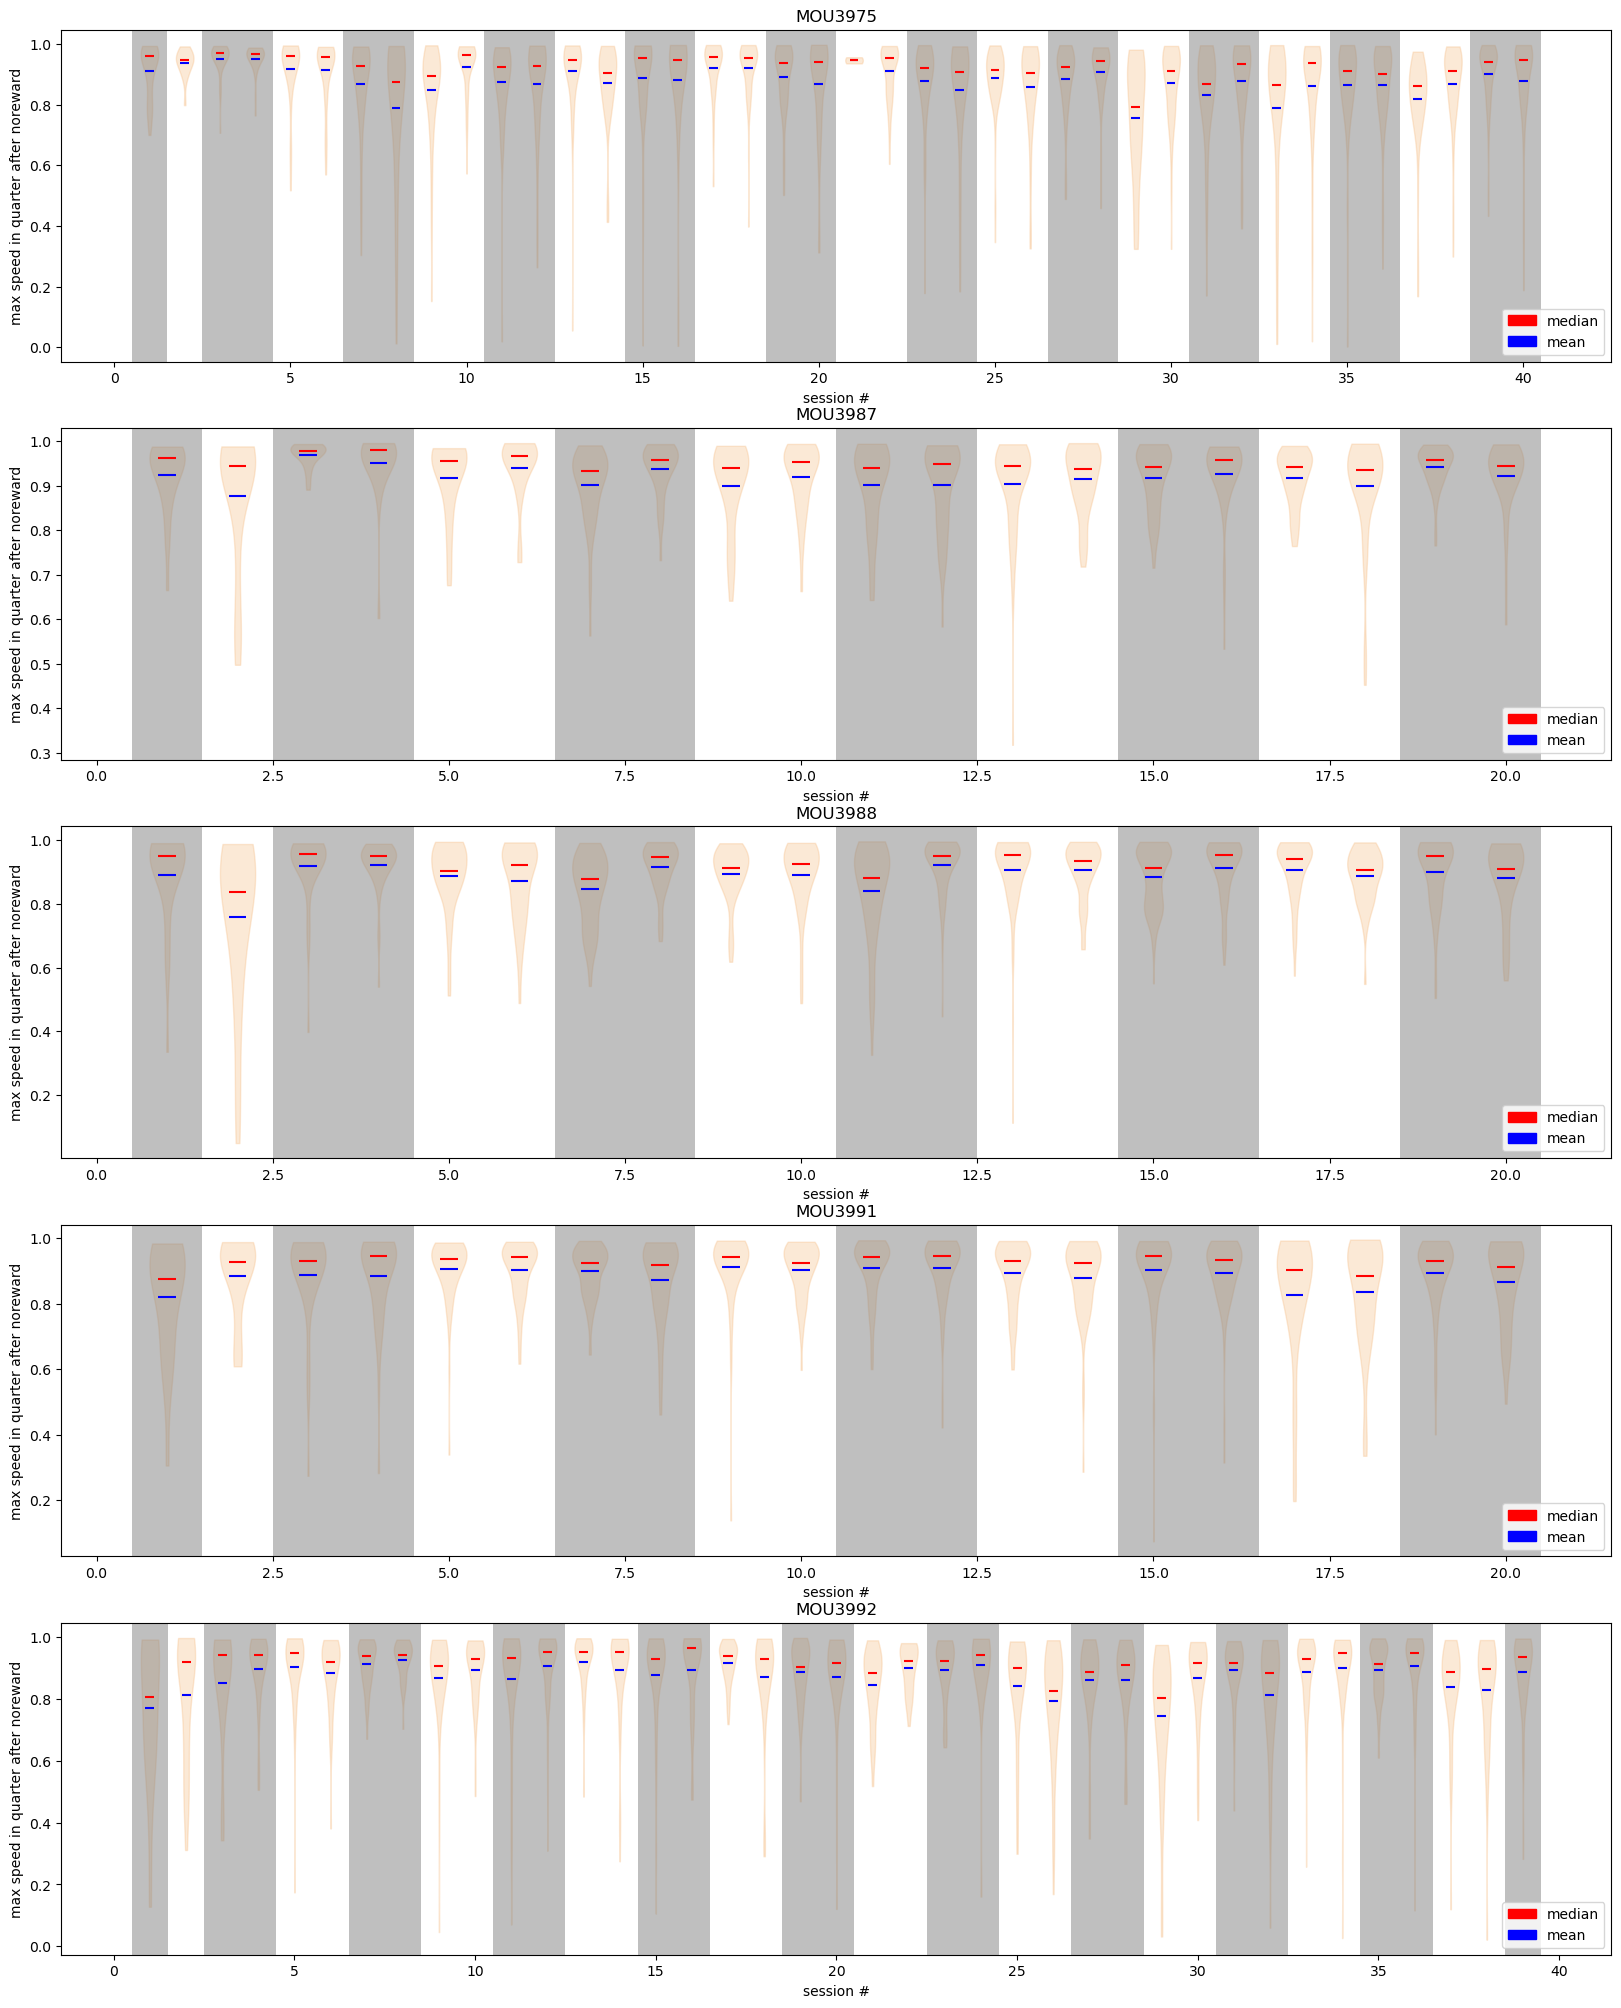

In [49]:
#function to get the results for Alice's Memoire

def speedMaxDuringQuarterTurn(df, list_epoch, session_info):
    speeds = [np.max([df.loc[df.index[indice], 'speed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="Q"] #get the list of max instantanious speed during epochs
    return speeds 

def medianSpeedDuringBetweenObjects(df, list_epoch, session_info):
    speeds = [np.median([df.loc[df.index[indice], 'speed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="B"] #get the list of max instantanious speed during epochs
    return speeds 

def medianSpeedDuringOtherMovement(df, list_epoch, session_info):
    speeds = [np.median([df.loc[df.index[indice], 'speed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="N"] #get the list of max instantanious speed during epochs
    return speeds 

def medianAngularSpeedDuringBetweenObjects(df, list_epoch, session_info):
    speeds = [np.median([df.loc[df.index[indice], 'angularSpeed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="B"] #get the list of max instantanious speed during epochs
    return speeds 

def medianAngularSpeedDuringQuarterTurn(df, list_epoch, session_info):
    speeds = [np.median([df.loc[df.index[indice], 'angularSpeed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="Q"] #get the list of max instantanious speed during epochs
    return speeds 

def qtBadDirectionFirst2Min(df, list_epoch, session_infos) : 
    if session_infos.loc[session_infos.index[0], "potentialRewardedDirections"] == "[270]" : 
        direction = "w"
    elif session_infos.loc[session_infos.index[0], "potentialRewardedDirections"] == "[90]" :
        direction = "k"
    else : return [-0.1]

    right_direction = [1 for epoch in list_epoch if df.loc[df.index[epoch[0]], "time"] <= 120 and epoch[2][0] == "Q" and epoch[2][1] == direction]
    bad_direction = [1 for epoch in list_epoch if df.loc[df.index[epoch[0]], "time"] <= 120 and epoch[2][0] == "Q" and epoch[2][1] != direction]
    try : 
       return [len(bad_direction)/(len(right_direction) + len(bad_direction))]
    except ZeroDivisionError : 
        return [-0.1]
    
def cherchequarttour(df, list_epoch, session_infos):
    total_quart =0

    for epoch in list_epoch : 
        if epoch[2][0] == "Q" : 
            total_quart += 1 
    return [total_quart]


def maxSpeedQuarterTurnAfterRewarderdedQuarter(df, list_epoch, session_infos) : 
    result = [np.max([df.loc[df.index[indice], 'speed']for indice in range(list_epoch[a][0], list_epoch[a][1] + 1)])for a in range(1, len(list_epoch)) if list_epoch[a][2][0] =="Q" and list_epoch[a - 1][2][0] =="Q" and list_epoch[a - 1][2][5] =="R"]
    if len(result) != 0 : return result
    else : return [0]

def maxSpeedQuarterTurnAfterNoRewardQuarter(df, list_epoch, session_infos) : 
    result = [np.max([df.loc[df.index[indice], 'speed']for indice in range(list_epoch[a][0], list_epoch[a][1] + 1)])for a in range(1, len(list_epoch)) if list_epoch[a][2][0] =="Q" and list_epoch[a - 1][2][0] =="Q" and list_epoch[a - 1][2][5] =="R"]
    if len(result) != 0 : return result
    else : return [0]

def directivityBetweenObject(df, list_epoch, session_infos): #take the ratio of the minimal distance to do if flying it on the observed observed distance done
    results = [(((df.loc[df.index[epoch[0]], 'xposition']-df.loc[df.index[epoch[1]], 'xposition'])**2+(df.loc[df.index[epoch[0]], 'yposition']-df.loc[df.index[epoch[1]], 'yposition'])**2)**0.5) * (0.84/512) / np.sum([df.loc[df.index[indice], 'distance'] for indice in range(epoch[0], epoch[1] + 1)]) for epoch in list_epoch if epoch[2][0] =="B"]
    if len(results) != 0 : return results
    else : return [0]


suiviVariable(fonction_variable= directivityBetweenObject, liste_souris= list_mouse_number, metaData= MetaData, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos,
              variableName= "directivity")

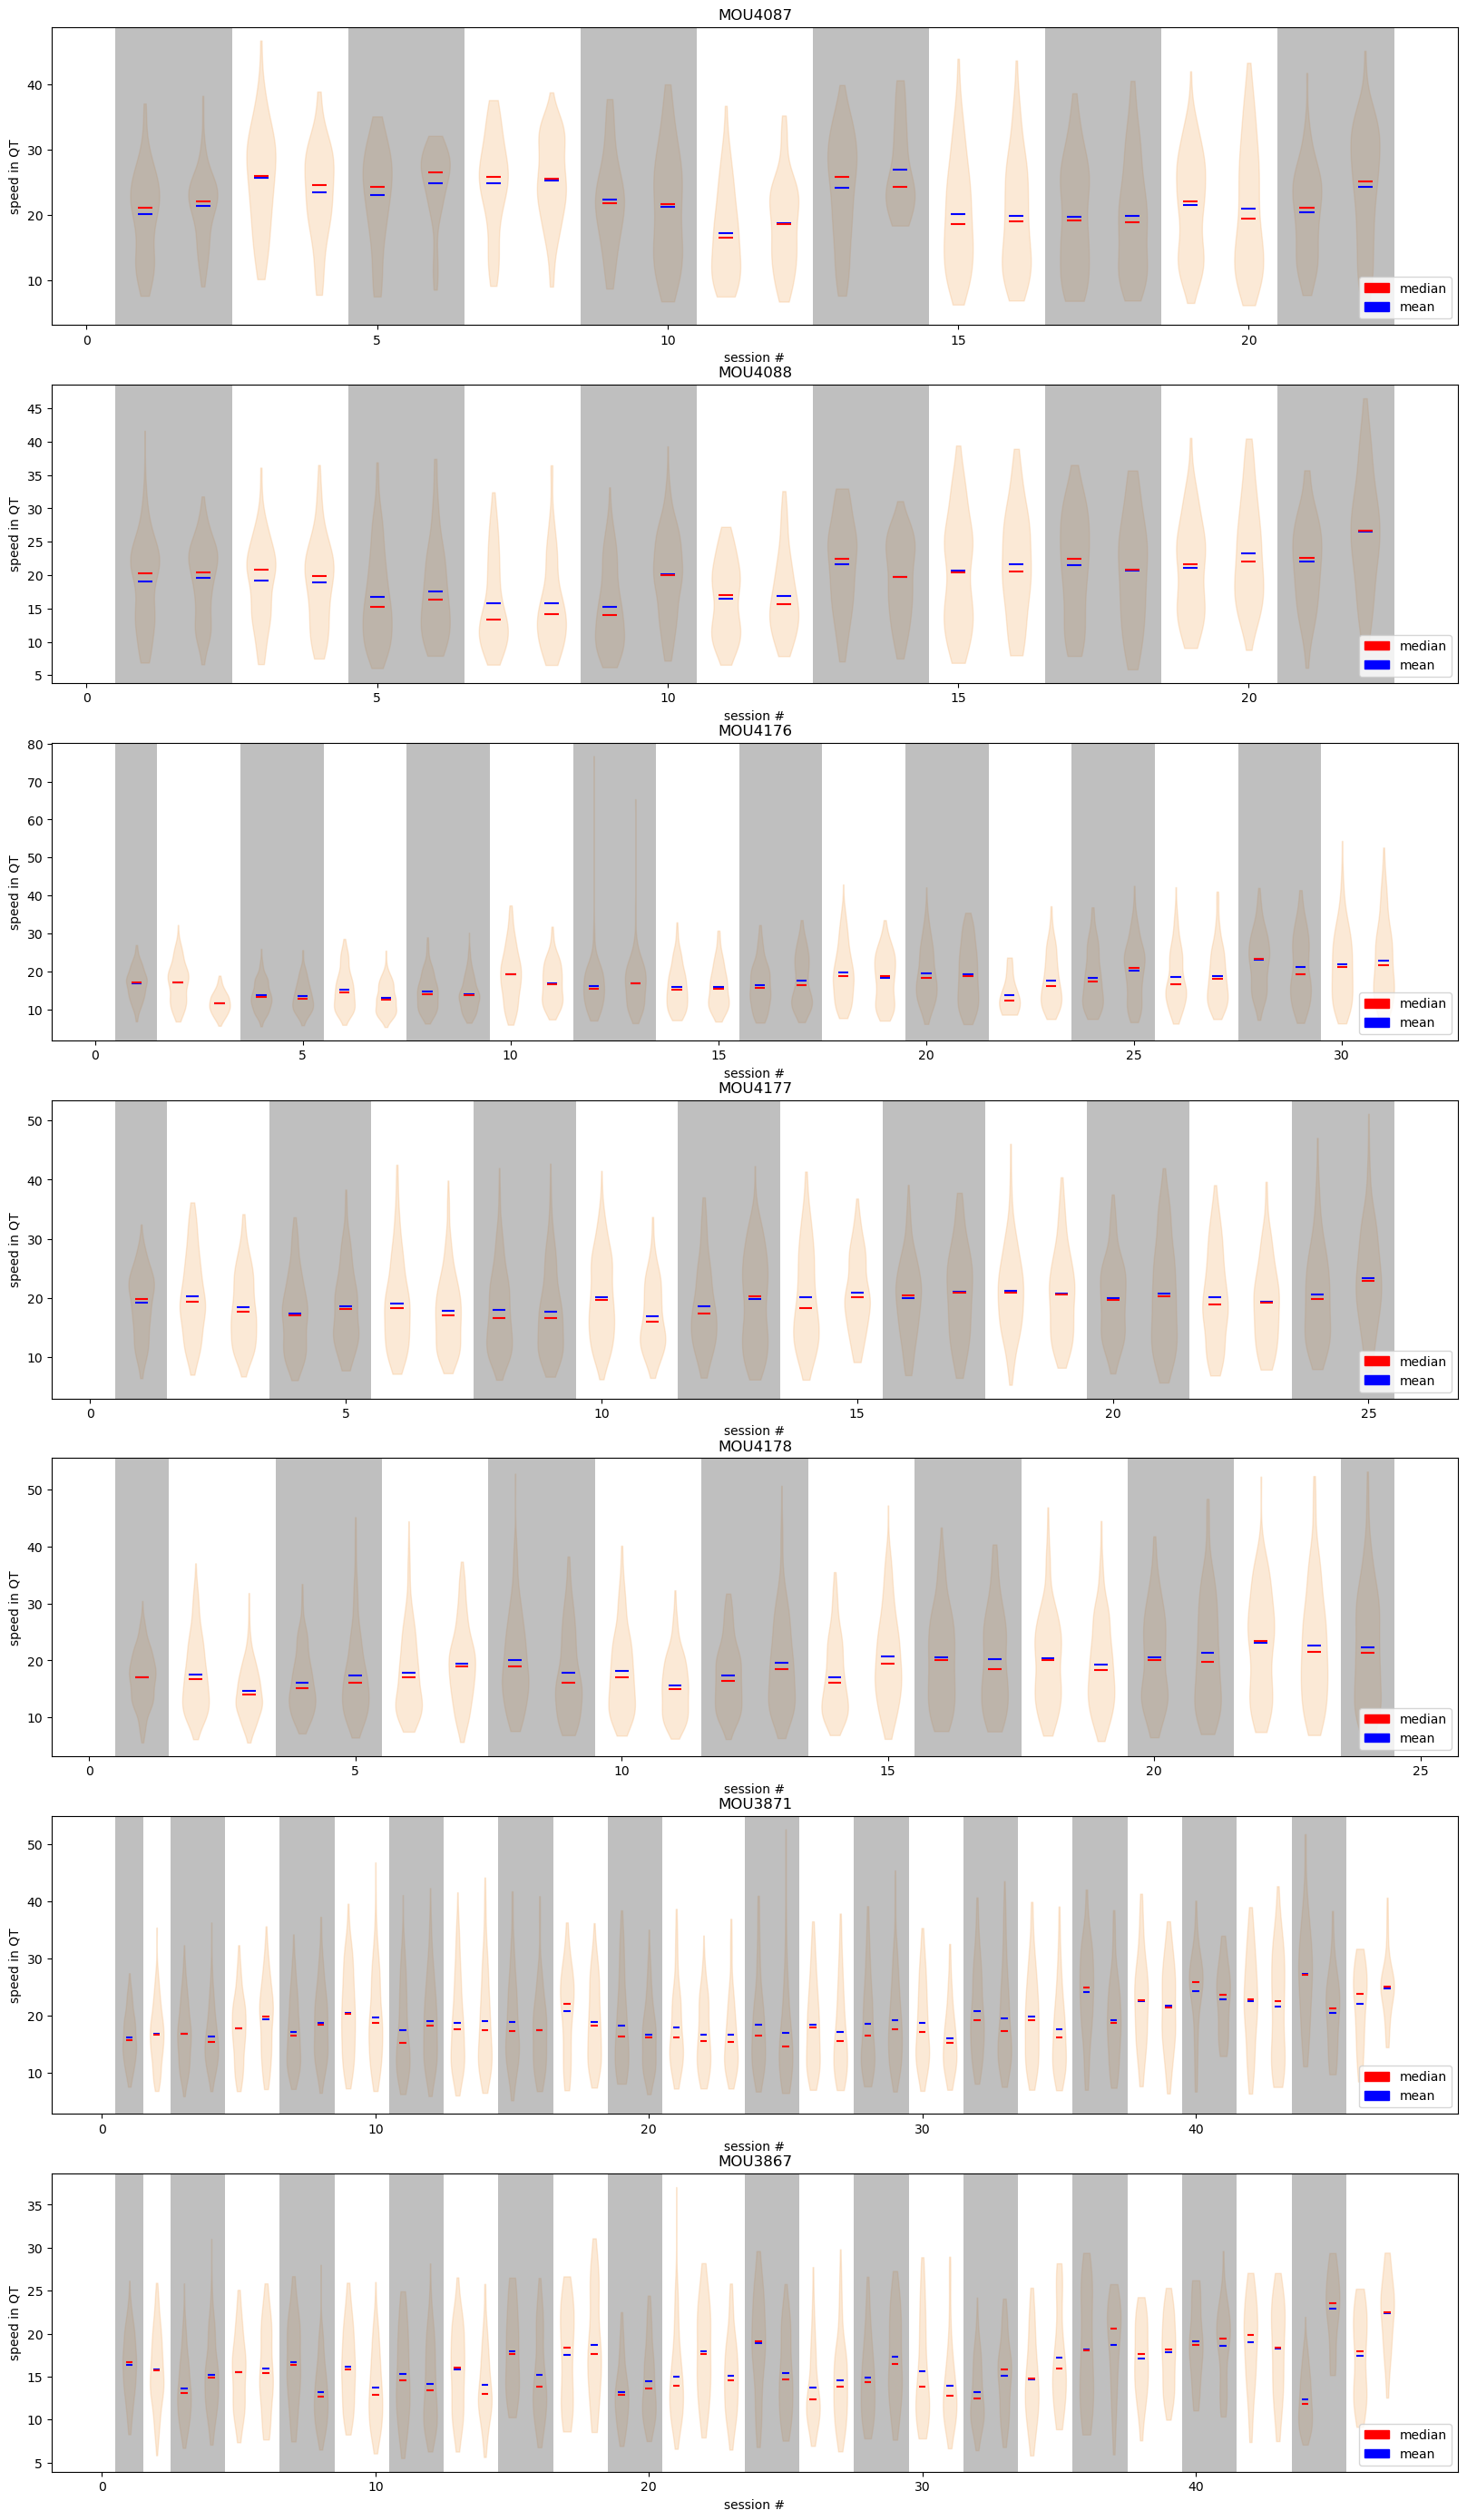

In [47]:
#Cell 4 : detailed example of a function to use with suiviVariable
list_mouse_number = ["MOU4087", "MOU4088","MOU4176", "MOU4177", "MOU4178", "MOU3871", "MOU3867"]


# The first line signal that it is the definition of a function, give the name of the function and the name of its arguments. Arguments are the informations the function get when its called.
# The name of the function is not important for the code to work, but using a clear name help to remember and to signal to other what it does
# The arguments of a function created to be used with suiviVariable must always be the same three as in the example 
def speedDuringEpoch(df, list_epoch, session_info):

    #this is a comprehension of list, which should be read in the following order : 
    # - the comprehension start with the oppening of the brackets "[" Then goes to the first for, which is a loop on all element of the list list_epoch. During each loop, the element of the list considered is called "epoch"
    # - we then continue to the element after the for, which turns out is another 'for'. The second for will be called in each loop of the first 'for'. This 'for' loop on the values between epoch[0] and epoch[1] (the last number of a range is 
    #           not comprised). 'Epoch' here being the value of the cell of the list we got in the previous list. Epoch[0] is the index of df where the epoch start and epoch[1] is the index of the last line to be part of an epoch.
    #           The value obtained on each of these loop is called 'indice'
    # - there is nothing after this second for so we go back to the beginning of the list comprehension to see which value will be added to the list. It is given by the formula "df.loc[df.index[indice], 'speed']" which means that in the dataframe 
    #           df we select the row number 'indice' (remember that it start at 0 in python) and in that row, take the column "speed". What we get is the value of speed for the corresponding row in the epoch
    #in the end, we obtain a list which contain each value of instantanious speed in an epoch for the session. This list is then assigned to the variable 'speed'
    speeds = [df.loc[df.index[indice], 'speed']  for epoch in list_epoch for indice in range(epoch[0], epoch[1] + 1)]

    #this second list comprehension is actually simplier than the first one. Its goal is to get rid of the top 10% and the bottom 10% of the values
    # - we take the list speed we juste created and use the function "sort" on it which put the values it contains in increasing order. The expression [a : b] signal that we only take the values from the indice a to b-1 in the list
    #       here a is the integer part of 10% of the size of the list, while b is the integer part of 90% of the size of the list
    # - we then loop on each of the value obtained and store it as it is in the variable no_extreme_list
    no_extreme_list = [speedy for speedy in np.sort(speeds)[int(len(speeds) * 0.1) : int(len(speeds) * 0.9)]]
    return no_extreme_list #return the speed wihout the extremes values. The return value must be a list. If you return a single value, your return must be written return [value]


def ratioTimeExploiting(df, list_epoch, session_info) : 

    # when an element after a 'for' in a list comprehension is a 'if', it means that we will do this passage of the loop only if the condition of the 'if' is true
    # here, we look at the value of epoch we got from list_epoch. We coninue this loop passage only if either in the third element of epoch, the first element is the letter 'Q' in majuscule (which means only if the the first letter of 
    #       the epoch identifier is a q, so if the epoch is a quarter turn) or if that same element is a majuscule 'B' (so if the epoch is a between object)
    # if the condition is true, then we go to the beginning of the list comprehension to get the value to store from the expression there. If the condition is not true, we go to the next loop passage
    duration = [df.loc[df.index[epoch[1]], 'time'] - df.loc[df.index[epoch[0]], 'time'] for epoch in list_epoch if epoch[2][0] == "Q" or epoch[2][0] == "B"]
    total_time = sum(duration)
    return [total_time / df.loc[df.index[-1], 'time']]




suiviVariable(liste_souris= list_mouse_number, metaData= MetaData, fonction_variable= speedDuringEpoch, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, variableName= "speed in QT", byDay= False)

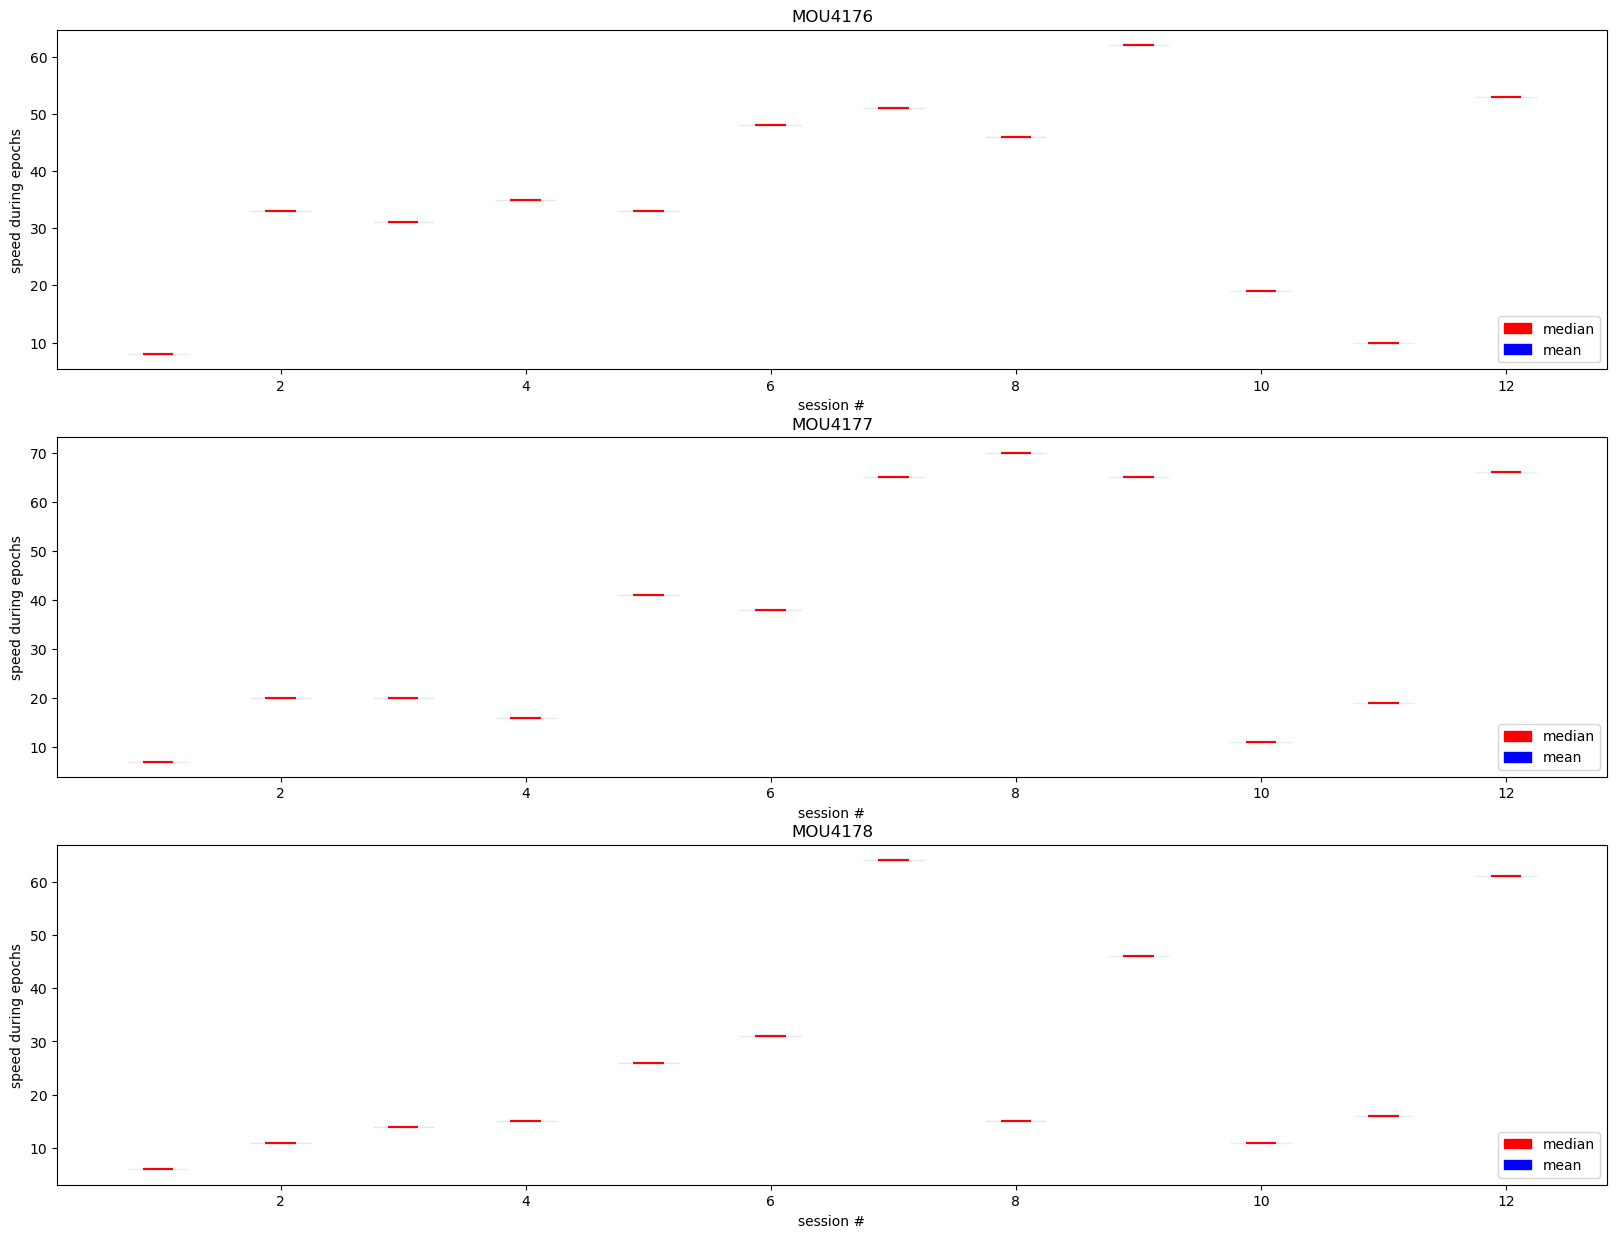

In [3]:
def cherchequarttourrecompense(df, list_epoch, session_infos):
    total_quart_recomp =0

    for epoch in list_epoch : 
        if epoch[2][0] == "Q" and epoch[2][2] == "G" : 
            total_quart_recomp += 1 
    return [total_quart_recomp]

list_mouse_number = ["MOU4087", "MOU4088","MOU4176", "MOU4177", "MOU4178", "MOU3871", "MOU3867"]


suiviVariable(liste_souris= list_mouse_number, metaData= MetaData, fonction_variable= cherchequarttourrecompense, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, variableName= "speed during epochs")

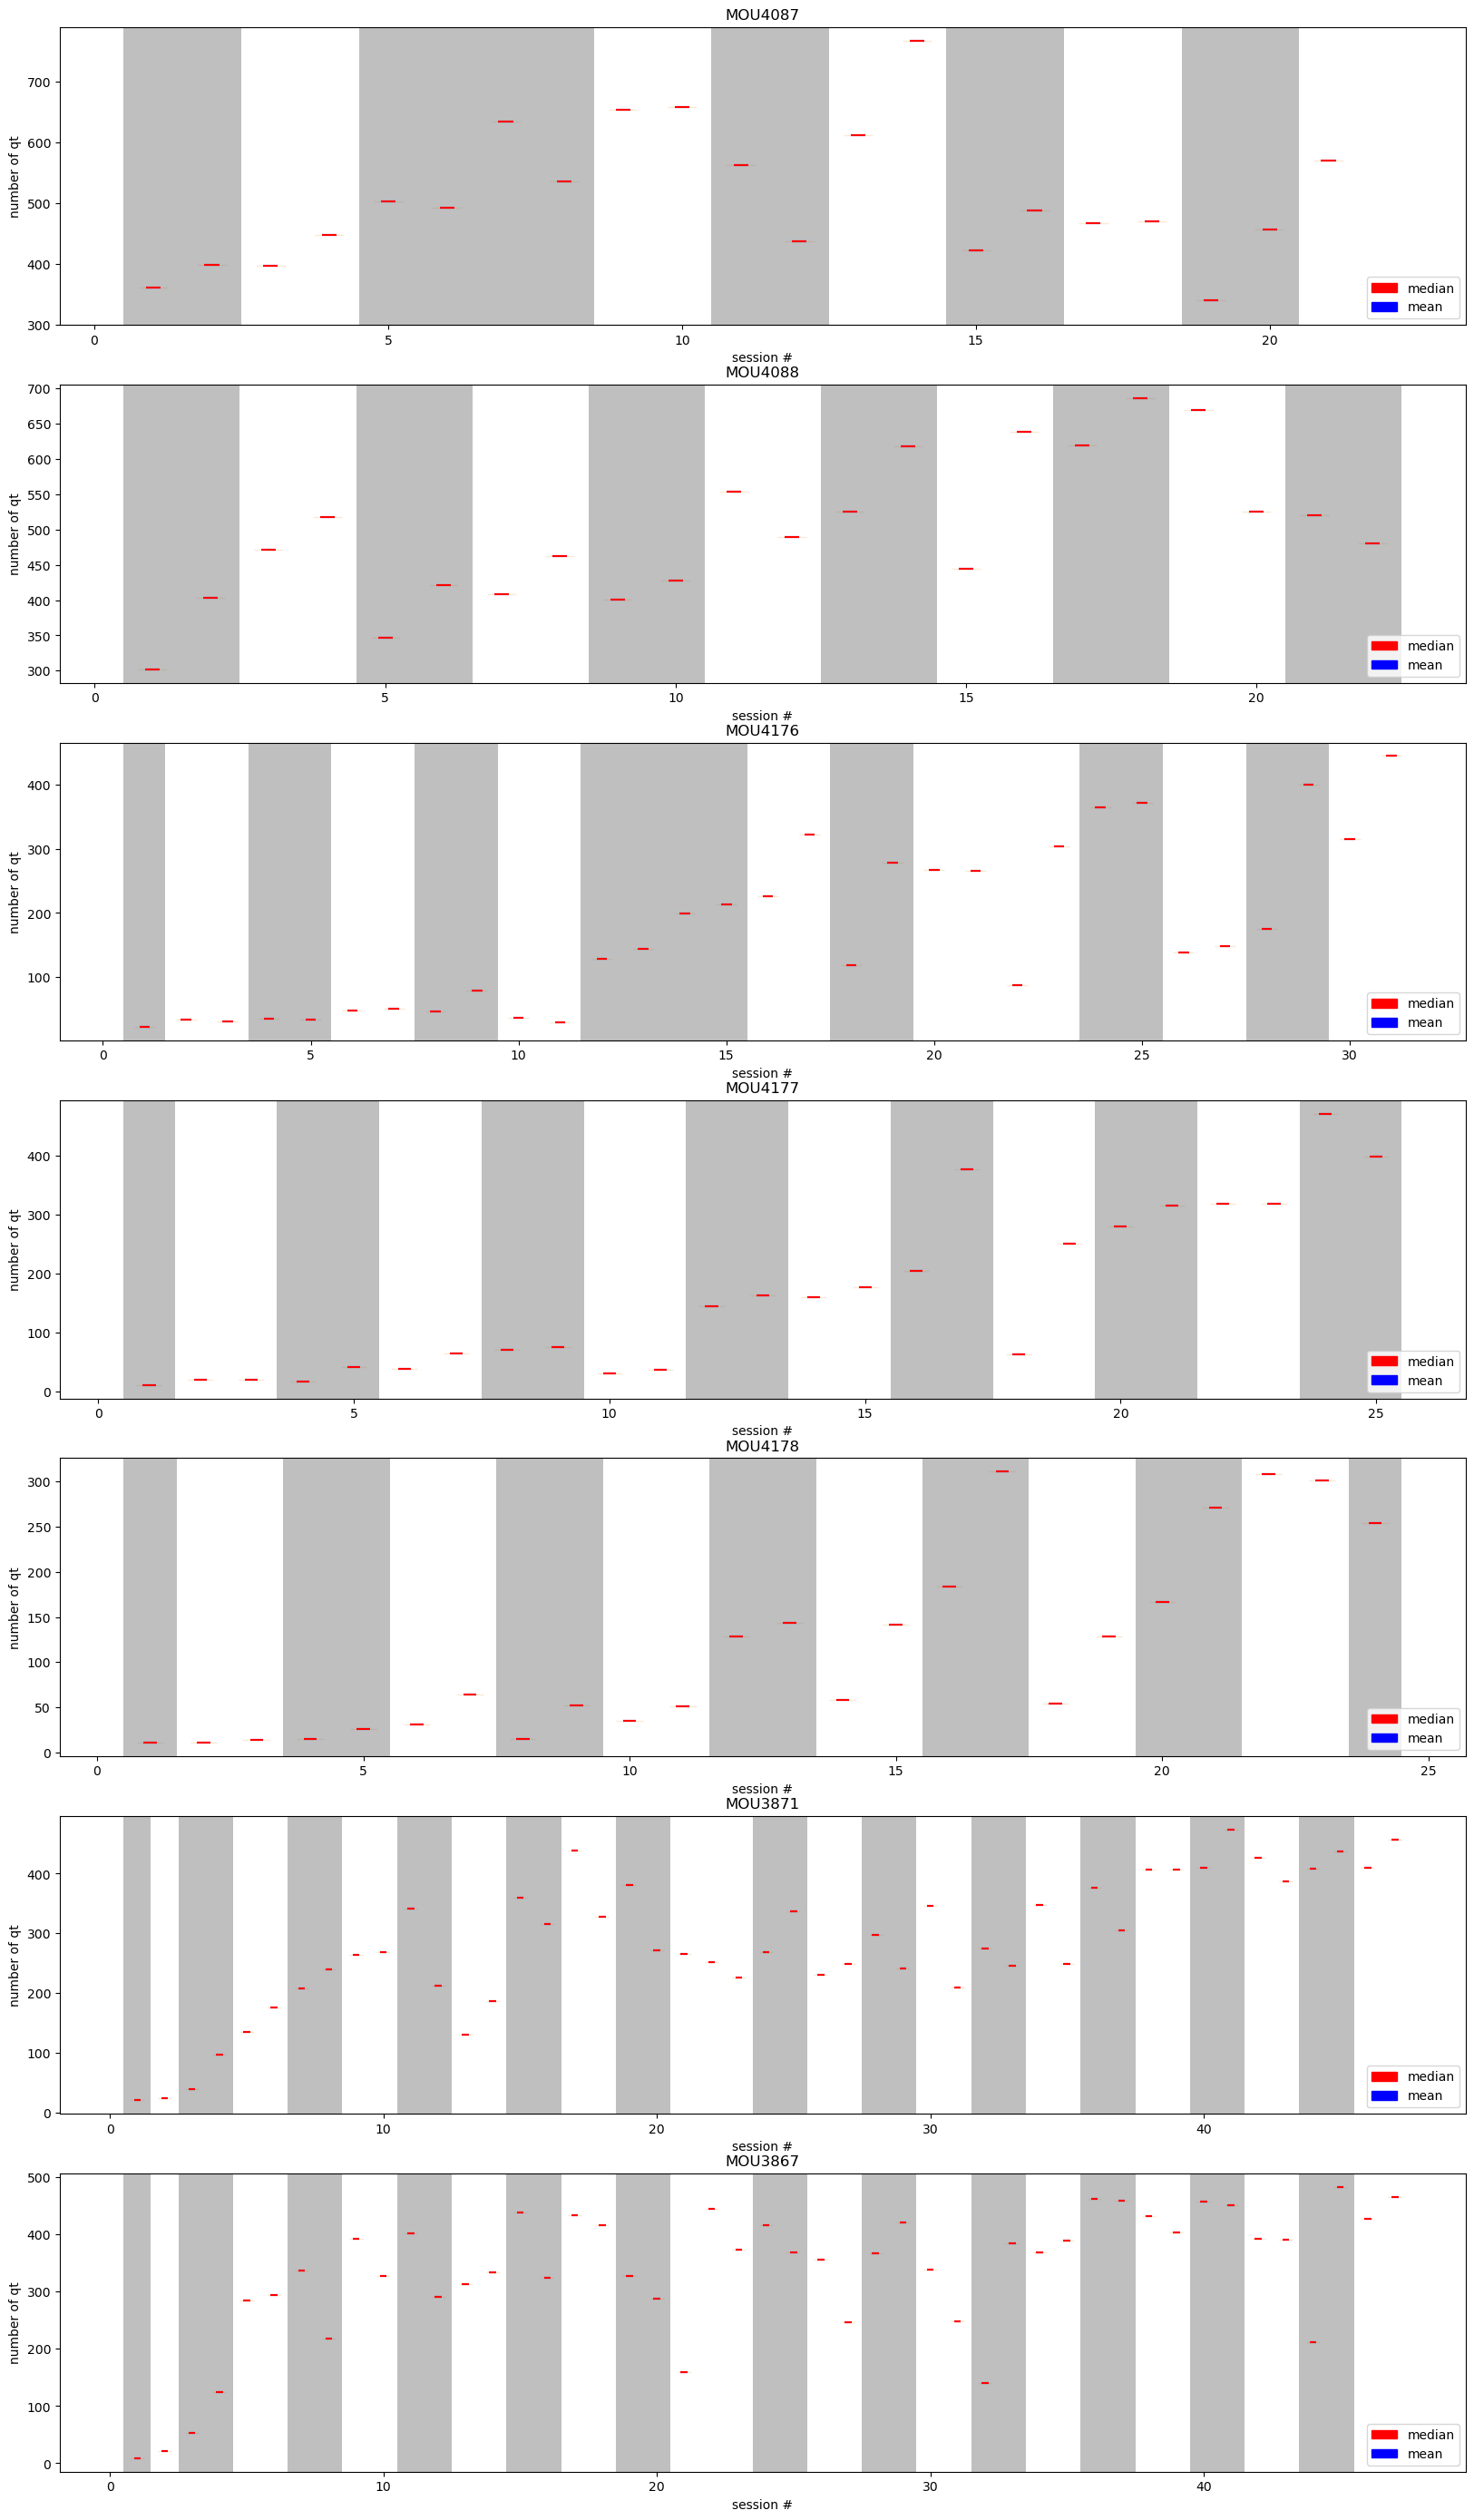

In [12]:
def cherchequarttour(df, list_epoch, session_infos):
    total_quart =0

    for epoch in list_epoch : 
        if epoch[2][0] == "Q" : 
            total_quart += 1 
    return [total_quart]

list_mouse_number = ["MOU4087", "MOU4088","MOU4176", "MOU4177", "MOU4178", "MOU3871", "MOU3867"]


suiviVariable(liste_souris= list_mouse_number, metaData= MetaData, fonction_variable= cherchequarttour, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, variableName= "number of qt")

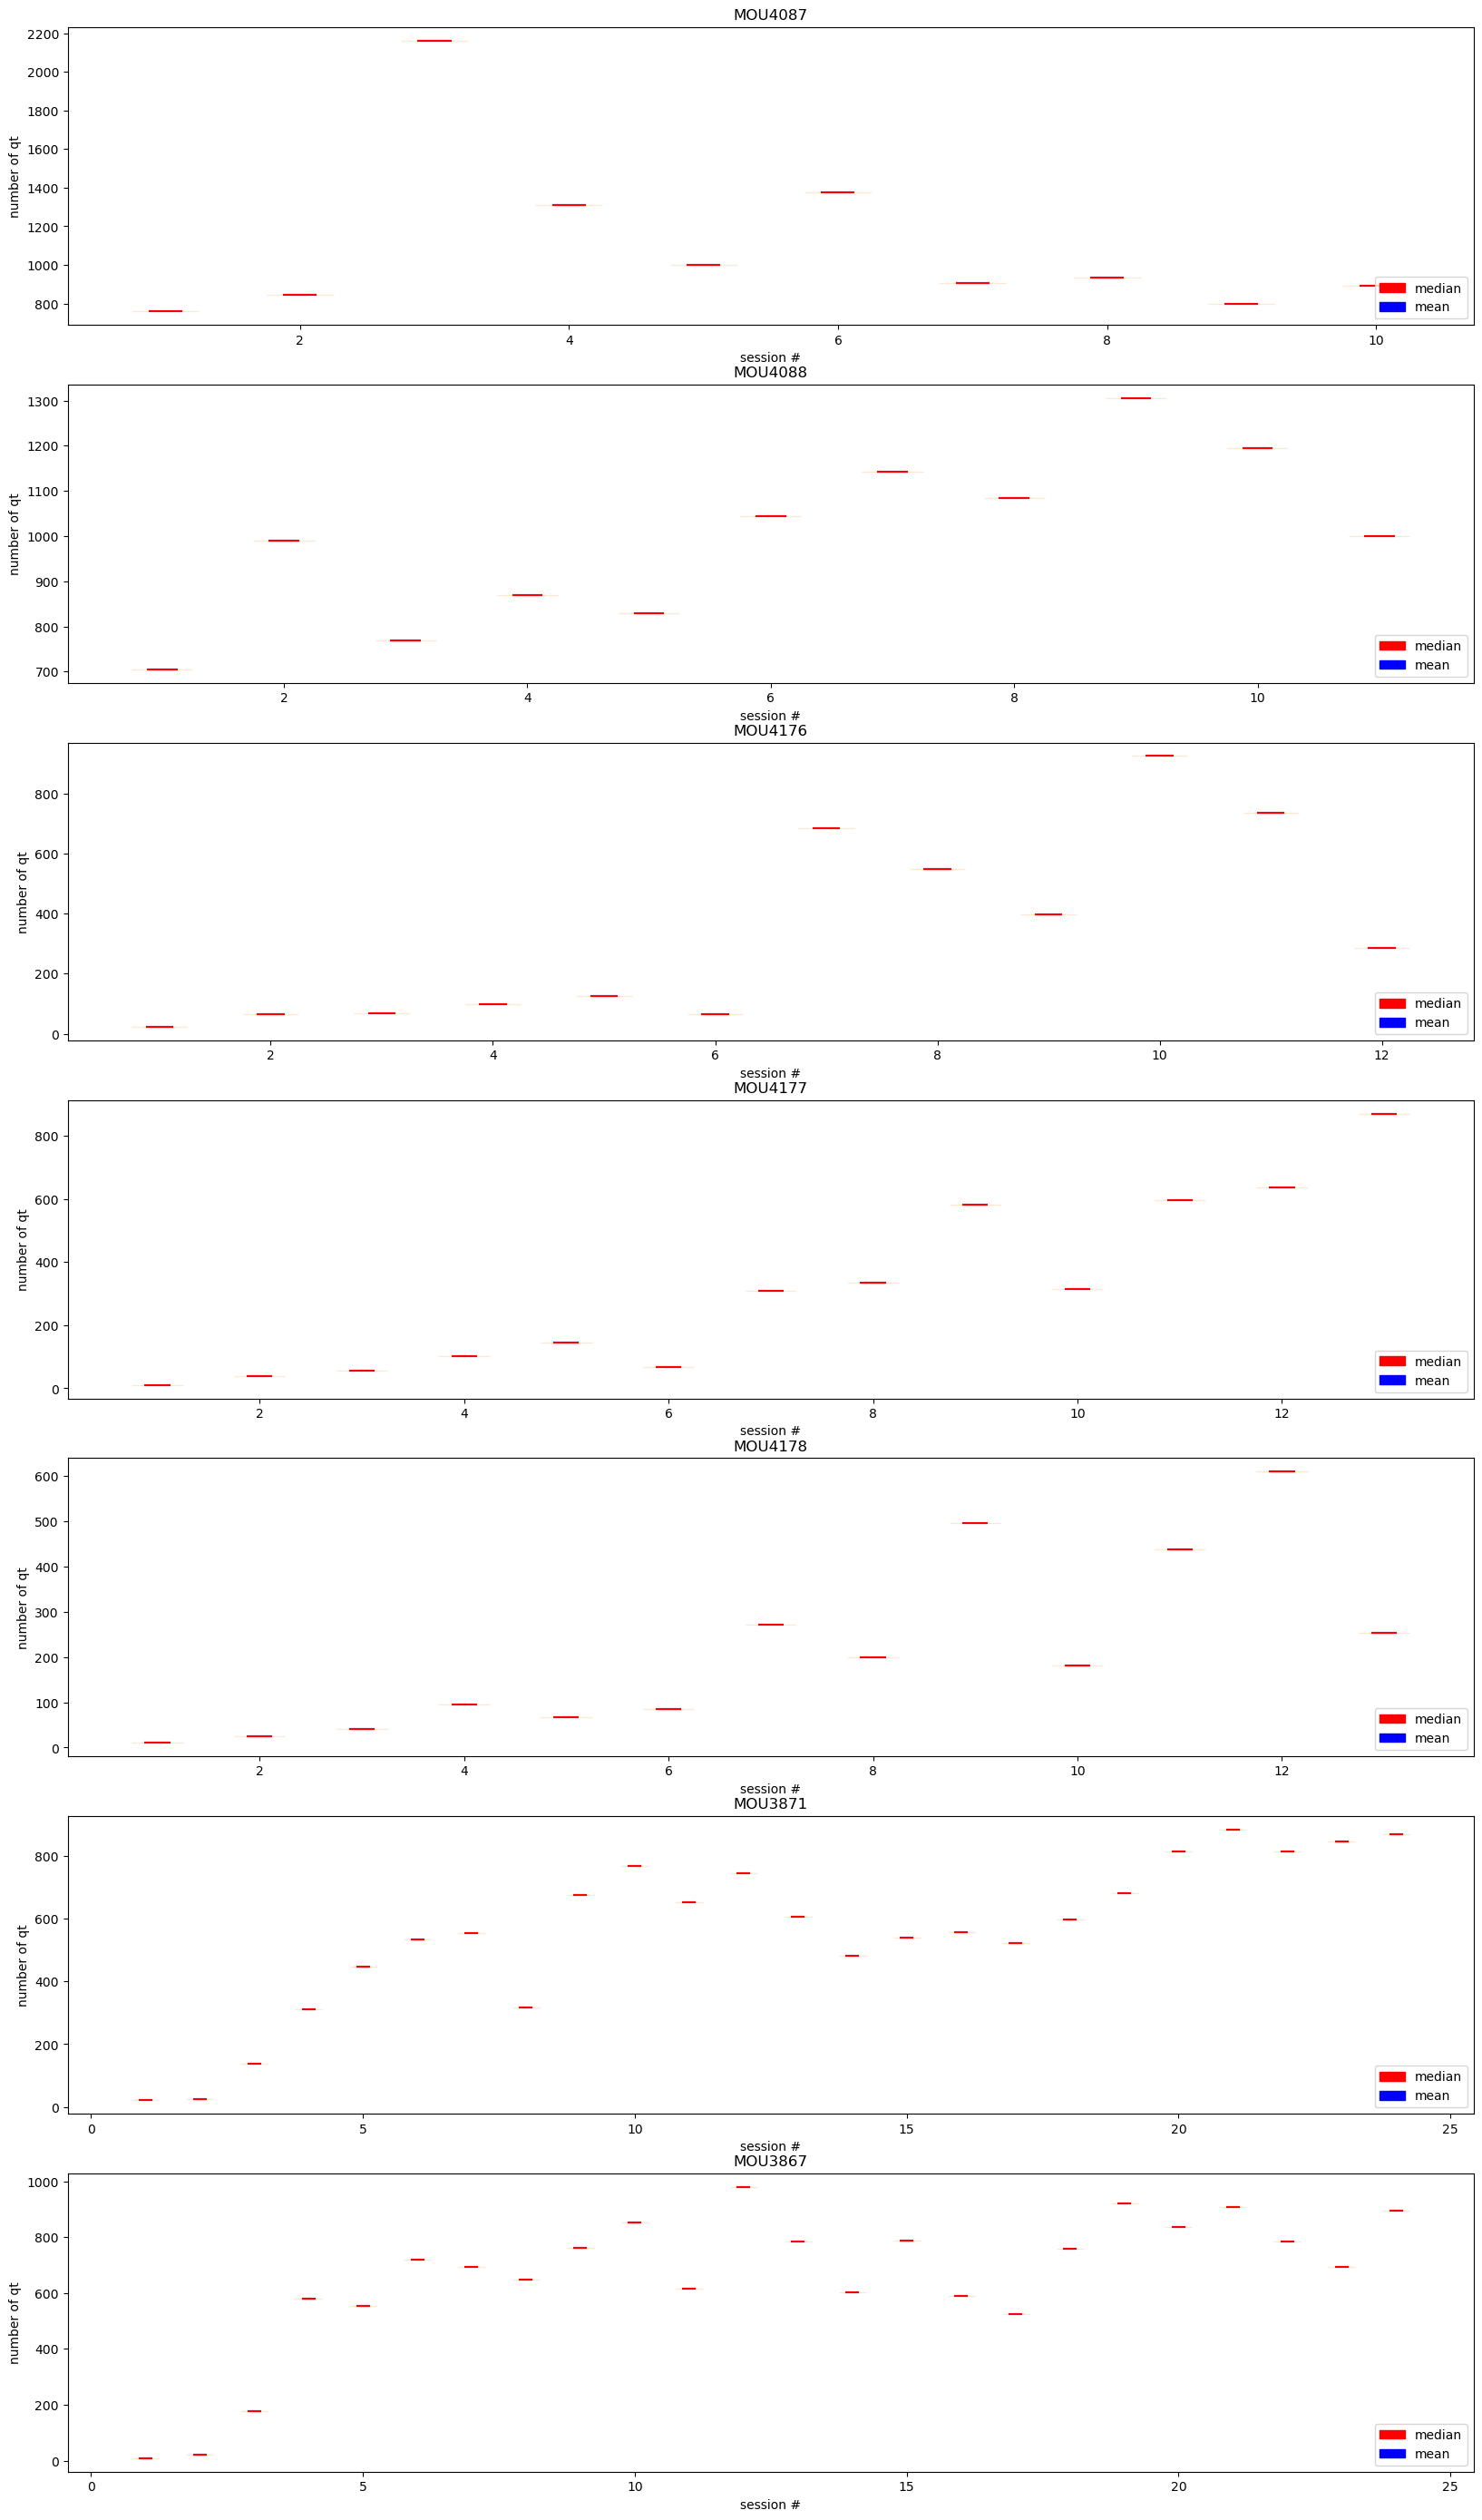

In [8]:
def sommer(truc) : return [sum(truc)]

list_mouse_number = ["MOU4087", "MOU4088","MOU4176", "MOU4177", "MOU4178", "MOU3871", "MOU3867"]


suiviVariable(liste_souris= list_mouse_number, metaData= MetaData, fonction_variable= cherchequarttour, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, variableName= "number of qt", byDay= True, result_treatment= sommer)

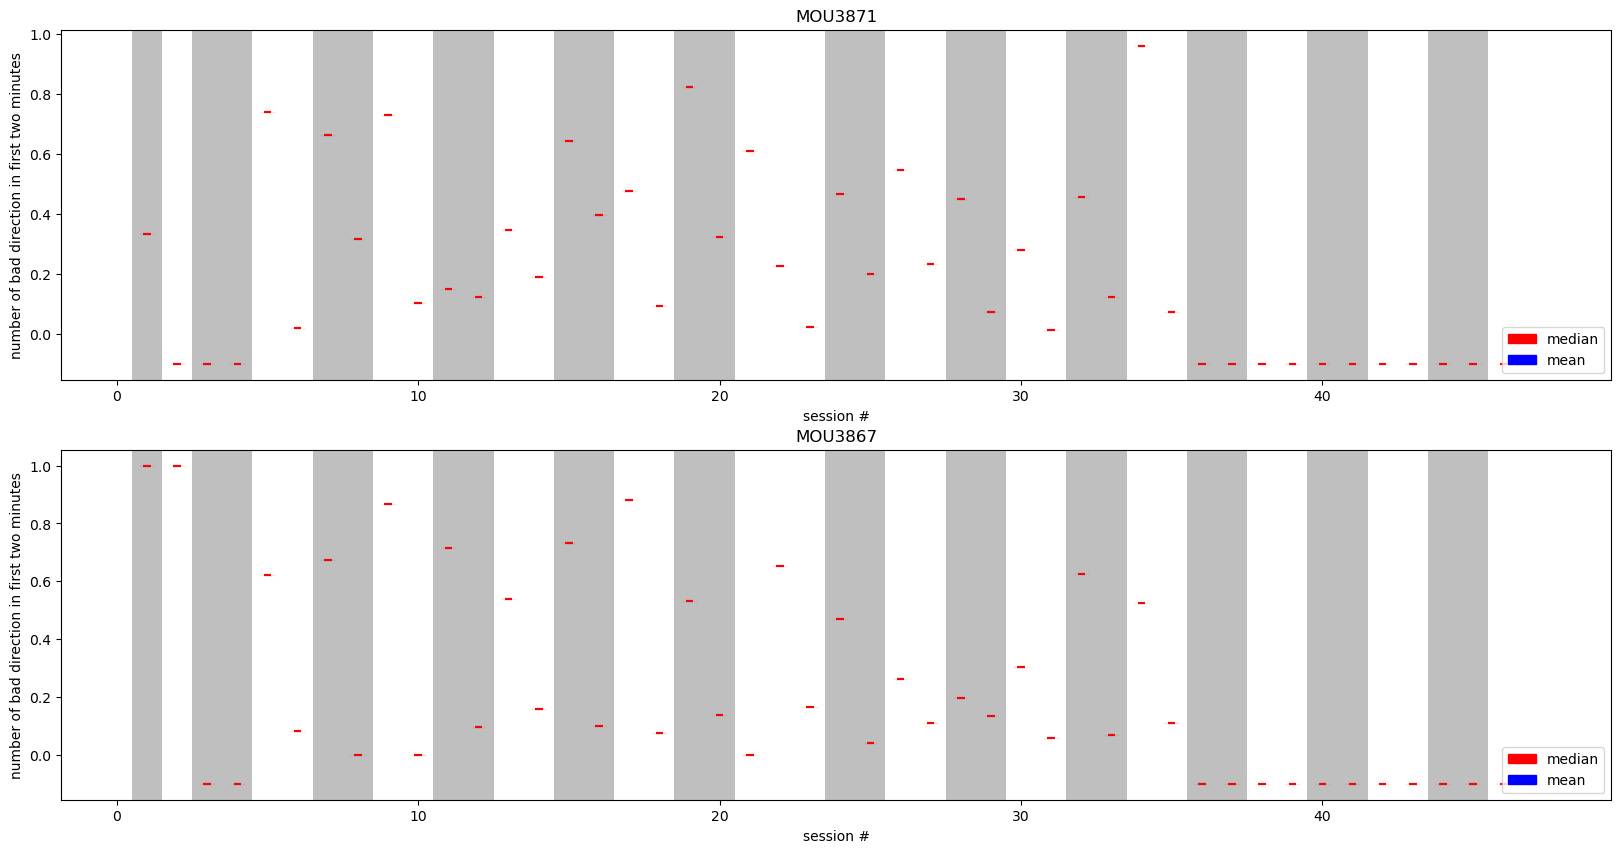

In [56]:
def qtBadDirectionFirst2Min(df, list_epoch, session_infos) : 
    if session_infos.loc[session_infos.index[0], "potentialRewardedDirections"] == "[270]" : 
        direction = "w"
    elif session_infos.loc[session_infos.index[0], "potentialRewardedDirections"] == "[90]" :
        direction = "k"
    else : return [-0.1]

    right_direction = [1 for epoch in list_epoch if df.loc[df.index[epoch[0]], "time"] <= 120 and epoch[2][0] == "Q" and epoch[2][1] == direction]
    bad_direction = [1 for epoch in list_epoch if df.loc[df.index[epoch[0]], "time"] <= 120 and epoch[2][0] == "Q" and epoch[2][1] != direction]
    try : 
       return [len(bad_direction)/(len(right_direction) + len(bad_direction))]
    except ZeroDivisionError : 
        return [-0.1]



list_mouse_number = ["MOU3871", "MOU3867"]

suiviVariable(liste_souris= list_mouse_number, metaData= MetaData, fonction_variable= qtBadDirectionFirst2Min, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, variableName= "number of bad direction in first two minutes")

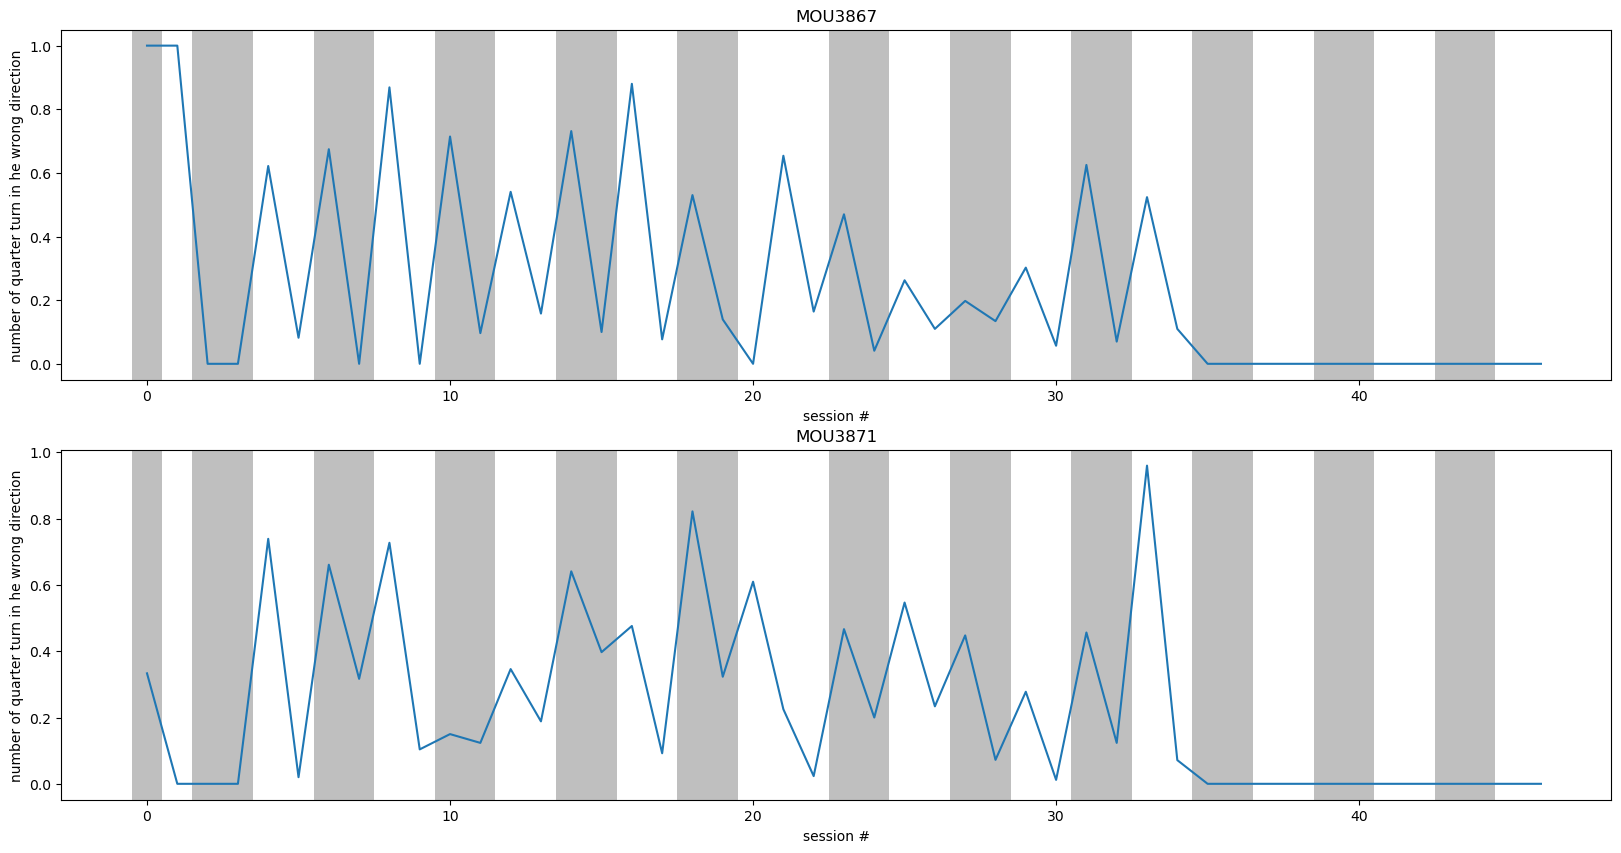

In [51]:
#This function creat a graph showing the number of quarter turn in the wrong direction in the first two minutes of the session and its evolution across sessions for each mouse in entry
#The values for the familiarization are wrong, and that's normal



def BadDirectionFirst2Min(liste_souris, metaEpoch, session_param, df ) : 

    resultats = {} # creat the dictionnary which will hold the result of the function calls
    span = {}
    for souris in liste_souris : 
        resultats[souris] = []
        span[souris] = []
    nb_line = len(liste_souris)
    

    for souris in liste_souris : 
        inaspan = False
        sessions_souris = list(session_param[souris].index)
        for a in range(len(sessions_souris)) :
            session = sessions_souris[a]

            if session_param[souris].loc[session, "timeOfDay"] == "M" : #if it is a morning session, change the background
                if not inaspan : #enter a colored area if it is not in one
                    span[souris].append([a -0.5, a + 0.5])
                    inaspan = True
                else : inaspan = False # signal that it have been 
            elif inaspan :
                span[souris][-1] = [span[souris][-1][0], span[souris][-1][1] + 1] #if this is an afternoon and the day is on a colored background, increase its withd to contain the session

            if session_param[souris].loc[session, "potentialRewardedDirections"] == "[270]" : 
                direction = "w"
            elif session_param[souris].loc[session,"potentialRewardedDirections"] == "[90]" :
                direction = "k"
            else : direction = ""

            if direction != "" :
                right_direction = [1 for epoch in metaEpoch[souris][session] if df.loc[df.index[epoch[0]], "time"] <= 120 and epoch[2][0] == "Q" and epoch[2][1] == direction]
                bad_direction = [1 for epoch in metaEpoch[souris][session] if df.loc[df.index[epoch[0]], "time"] <= 120 and epoch[2][0] == "Q" and epoch[2][1] != direction]
                try : 
                    resultats[souris].append([len(bad_direction)/(len(right_direction) + len(bad_direction))])
                except ZeroDivisionError : 
                    resultats[souris].append([0])
            else : resultats[souris].append([0])

    
    plt.figure(figsize=(20, 5 * nb_line)) #setup the dimension of the result

    for a in range(nb_line): #loop on each mouse to print their results 
        plt.subplot(nb_line, 1, a+1) #select the corresponding subplot

        plt.plot(resultats[liste_souris[a]])#creat the violinplot

        for i in span[souris] : 
            plt.axvspan(i[0], i[1], facecolor='grey', alpha=0.5)
        plt.xlabel("session #")
        plt.ylabel("number of quarter turn in he wrong direction")
        plt.title(liste_souris[a])
    plt.show()
    return


            ############
            #Use plt.axvspan(i, i+.5, facecolor='b', alpha=0.5)
            ###########
            
    
    
BadDirectionFirst2Min(liste_souris= ["MOU3867", "MOU3871"], metaEpoch= Meta_list_epoch, session_param= Meta_session_infos, df= MetaData)

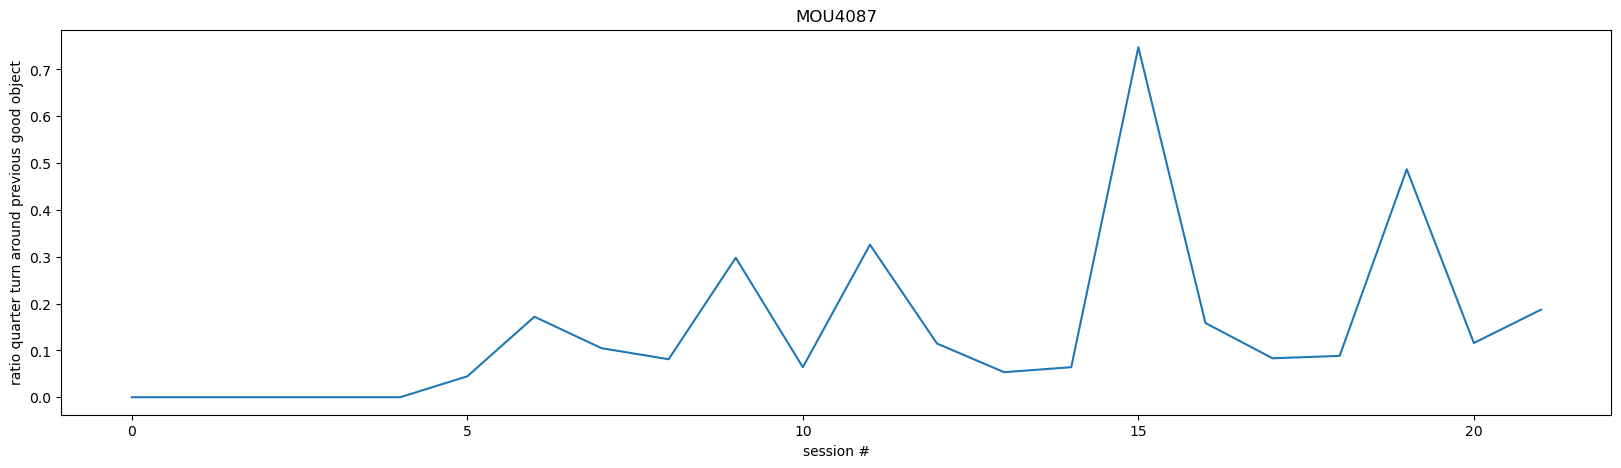

In [26]:
#this function show the ratio of turn done around the object which was the best object in the previous session, and its evolution, for each mouse in entry. Work only for habitat protocol (as it is the only concerned)

def turnsPreviousGood(liste_souris, metaEpoch, session_param, value_max_proba) : 

    nb_line = len(liste_souris)

    resultats = {} # creat the dictionnary which will hold the result of the function calls
    for souris in liste_souris : resultats[souris] = [0] #The first session cannot have a result as their is no previous good object yet

    for souris in liste_souris : 
        sessions_souris = list(session_param[souris].index)
        for a in range(len(sessions_souris) - 1) : #loop on each session for each mouse, except the last one

            previous_session = sessions_souris[a] #keep the name of the function we are currently working with
            noProba = True # until proven otherwise, the current session does not have probabilities
            bestPrevious = "" # until we know wich is the 

            if session_param[souris].loc[previous_session, "probaNW"] == value_max_proba : #check if one of the object was the right one. If so, note it down
                noProba = False
                bestPrevious = "NW"
            elif session_param[souris].loc[previous_session, "probaNE"] == value_max_proba : 
                noProba = False
                bestPrevious = "NE"
            elif session_param[souris].loc[previous_session, "probaSE"] == value_max_proba : 
                noProba = False
                bestPrevious = "SE"
            elif session_param[souris].loc[previous_session, "probaSW"] == value_max_proba : 
                noProba = False
                bestPrevious = "SW"
            
            if noProba : resultats[souris].append(0) #
            else : #If we found a rewarded object on the session
                next_session = sessions_souris[a + 1]
                liste_epoch = [epoch[2][3:5] for epoch in metaEpoch[souris][next_session] if epoch[2][0] == "Q"] #keep the object around which the quarter turns of the session have been done
                nb_total_quarter = len(liste_epoch)
                nb_quarter_around_previous = len([1 for epoch in liste_epoch if epoch == bestPrevious])
                resultats[souris].append(nb_quarter_around_previous / nb_total_quarter) #add the ratio of the nb of quarter turn around the previously good object to the results list
                
    plt.figure(figsize=(20, 5 * nb_line)) #setup the dimension of the result

    for a in range(nb_line): #loop on each mouse to print their results 
        plt.subplot(nb_line, 1, a+1) #select the corresponding subplot

        plt.plot(resultats[liste_souris[a]])#creat the violinplot

        
        plt.xlabel("session #")
        plt.ylabel("ratio quarter turn around previous good object")
        plt.title(liste_souris[a])
    plt.show()
    return
            # resultats[souris].append(fonction_variable(metaData.loc[metaData.index[start_data: end_data]], liste_epoch, meta_session_info[souris].loc[meta_session_info[souris].index == session])) #actual function call
    
turnsPreviousGood(liste_souris= ["MOU4087"], metaEpoch= Meta_list_epoch, session_param= Meta_session_infos, value_max_proba= 0.6)

Main function for statistical test. Get a function to get a variable in a session and two list of sessions for a mouse (first the control then the test) and do a rank-sum test on them 
The output are a list containg two list with the values of the variables considered. The first are the values taken by the control, the second the values taken by the test sessions. The second part of the output is the p_value for the test between those two

The functions used by stats_between_two_sessions are similar to those used by suivivariable, but must accept a fourth argument : dfturns (meaning that their arguments are (df, list_epoch, session_infos, dfturns) )

In [7]:
def stats_between_two_sessions(fonction_variable, mouse_name, list_session_names, metaData, meta_list_epoch, meta_session_info, meta_turn_info, variableName = ""):
    """
    function which show the statistical difference between both groups of sessions

    fonction_variable : function which take in entry the part of MetaData corresponding to the session then the list_epoch for the session and give back the variable for the session under the form of a list of values
    mouse_name : (string) name of the mouse
    list_session_names : list of list of strings under the format [['name of control session 1', 'name of control session 2',...], ['name of CNO session 1', 'name of CNO session 2', ...]]
    metaData : the dataframe MetaData obtained in the first cell
    meta_list_epoch : the dataframe Meta_list_epoch obtained in the first cell
    meta_session_info : the dictionnary of dataframes Meta_session_info obtained in the first cell
    variableName : (string) the name given of the y axis
    meta_turn_info : Meta_turn
    """


    variable_for_the_session = [[], []]
    
    for type_session in range(2) : 
        length = len(list_session_names[type_session])
        for iterateur in range(length) : #loop on each session for each mouse
            session = list_session_names[type_session][iterateur]
            #meta_session_info[mouse_name].loc[meta_session_info[mouse_name].index == list_session_names[a]]


            start_data = meta_session_info[mouse_name].loc[session, "startPosition"]#get the start and end indice for the session (on the metadata dataframe)
            end_data = meta_session_info[mouse_name].loc[session, "endPosition"]
            start_turn = meta_session_info[mouse_name].loc[session, "startTurns"]
            end_turn = meta_session_info[mouse_name].loc[session, "endTurns"]
            liste_epoch = [[epoch[0] - start_data, epoch[1] - start_data, epoch[2]] for epoch in meta_list_epoch[mouse_name][session]] #get the correct indice on the epoch for a reduce dataframe

            variable_for_the_session[type_session] = variable_for_the_session[type_session] + fonction_variable(metaData.loc[metaData.index[start_data: end_data]], liste_epoch, meta_session_info[mouse_name].loc[meta_session_info[mouse_name].index == session], meta_turn_info.loc[meta_turn_info.index[start_turn: end_turn]]) #actual function call

    statistic, p_value = stats.mannwhitneyu(variable_for_the_session[0], variable_for_the_session[1])
    print(f"rank-sum test on {variableName} \n statistic = {statistic} \n p_value = {p_value} \n n = {len(variable_for_the_session[1])} for the CNO \n n = {len(variable_for_the_session[0])} for the control")
    print(f"CONTROL median : {np.quantile(variable_for_the_session[0], 0.5)}, first quartile : {np.quantile(variable_for_the_session[0], 0.25)}, third quartile : {np.quantile(variable_for_the_session[0], 0.75)}") 
    print(f"CNO median : {np.quantile(variable_for_the_session[1], 0.5)}, first quartile : {np.quantile(variable_for_the_session[1], 0.25)}, third quartile : {np.quantile(variable_for_the_session[1], 0.75)}")

    return variable_for_the_session, p_value





In [4]:
#this function send back the number of turn done in a patch before leaving it, while elliminating the passages in the patches which does not have any stops
# because the animal probably juste went right through it or, at least, did not tried to get a reward
def howturnB4Going(df, list_epoch, session_infos, dfturns) : 

    #creat a list of the passages in a patch. It contains : patch identifier, time of entry, time of leaving, number of turn done in it
    #until the moment where the animal leave the patch is found, it is initialized as the end of the session
    patch_historic = [[patchNumber(df.loc[df.index[0], "xposition"], df.loc[df.index[0], "yposition"], Resolution), df.loc[df.index[0], "time"], df.loc[df.index[-1], "time"], 0]]
    
    for a in range(1, len(df.index)) : #check when a patch change is done across all frames
        if patchNumber(df.loc[df.index[a], "xposition"], df.loc[df.index[a], "yposition"], Resolution) != patch_historic[-1][0] : 

            patch_historic[-1][2] = df.loc[df.index[a], "time"]#if the animal leave 
            patch_historic.append([patchNumber(df.loc[df.index[a], "xposition"], df.loc[df.index[a], "yposition"], Resolution), df.loc[df.index[a], "time"], df.loc[df.index[-1], "time"], 0])
            

    for a in range(len(dfturns.index)) :#identify in which patch passage the turns have been made
        i = 0 
        #look for the passage encapsulating the time of the turn
        while patch_historic[i][2] < dfturns.loc[dfturns.index[a], "time"] : 
            i += 1

        if dfturns.loc[dfturns.index[a], "time"] < patch_historic[i][1] : 
            raise ValueError(f"turn {a} in dfturns should be in entry {i} of patch_historic but is not")
        else :
            patch_historic[i][3] = 1 + patch_historic[i][3] #add one to the counter of turns done in this passage

    timeInPatch = [] #keep the passages where the animal at least tried to get a reward
    for passage in patch_historic : 
        if passage[3] != 0 : 
            timeInPatch.append(passage[3])
    if len(timeInPatch) != 0 : return timeInPatch
    else : return [0]


def speedMaxDuringQuarterTurnB(df, list_epoch, session_info, dfturns):
    speeds = [np.max([df.loc[df.index[indice], 'speed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="Q"] #get the list of max instantanious speed during epochs
    return speeds 


def medianSpeedDuringBetweenObjectsB(df, list_epoch, session_info, dfturns):
    speeds = [np.median([df.loc[df.index[indice], 'speed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="B"] #get the list of max instantanious speed during epochs
    return speeds 

def medianSpeedDuringOtherMovementB(df, list_epoch, session_info, dfturns):
    speeds = [np.median([df.loc[df.index[indice], 'speed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="N"] #get the list of max instantanious speed during epochs
    return speeds 

def maxAbsoluteAngularSpeedDuringBetweenObjectsB(df, list_epoch, session_info, dfturns):
    speeds = [np.max([abs(df.loc[df.index[indice], 'angularSpeed']) for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="B"] #get the list of max instantanious speed during epochs
    return speeds 

def maxAbsoluteAngularSpeedDuringQuarterTurnB(df, list_epoch, session_info, dfturns):
    speeds = [np.max([abs(df.loc[df.index[indice], 'angularSpeed']) for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="Q"] #get the list of max instantanious speed during epochs
    return speeds 

def maxSpeedQuarterTurnAfterRewarderdedQuarterB(df, list_epoch, session_infos, dfturns) : 
    result = [np.max([df.loc[df.index[indice], 'speed']for indice in range(list_epoch[a][0], list_epoch[a][1] + 1)])for a in range(1, len(list_epoch)) if list_epoch[a][2][0] =="Q" and list_epoch[a - 1][2][0] =="Q" and list_epoch[a - 1][2][5] =="R"]
    if len(result) != 0 : return result
    else : return [0]

def maxSpeedQuarterTurnAfterNoRewardQuarterB(df, list_epoch, session_infos, dfturns) : 
    result = [np.max([df.loc[df.index[indice], 'speed']for indice in range(list_epoch[a][0], list_epoch[a][1] + 1)])for a in range(1, len(list_epoch)) if list_epoch[a][2][0] =="Q" and list_epoch[a - 1][2][0] =="Q" and list_epoch[a - 1][2][5] =="R"]
    if len(result) != 0 : return result
    else : return [0]

def directivityBetweenObjectB(df, list_epoch, session_infos, dfturns): #take the ratio of the minimal distance to do if flying it on the observed observed distance done
    results = [((((df.loc[df.index[epoch[0]], 'xposition']-df.loc[df.index[epoch[1]], 'xposition'])**2+(df.loc[df.index[epoch[0]], 'yposition']-df.loc[df.index[epoch[1]], 'yposition'])**2)**0.5)) * (0.84 / 512) / np.sum([df.loc[df.index[indice], 'distance'] for indice in range(epoch[0], epoch[1] + 1)]) for epoch in list_epoch if epoch[2][0] =="B"]
    if len(results) != 0 : return results
    else : return [0]

rank-sum test on directivity 
 statistic = 10986.0 
 p_value = 0.053743050886223234 
 n = 101 for the CNO 
 n = 250 for the control
CONTROL median : 3.0, first quartile : 3.0, third quartile : 6.0
CNO median : 4.0, first quartile : 3.0, third quartile : 7.0


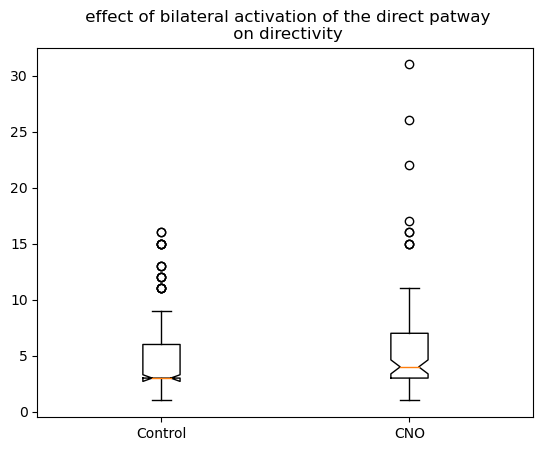

Median of CNO : 4.0 
 Median of control : 3.0


In [14]:
# Mou3992 phase 3 ["MOU3992_20230313-1213", "MOU3992_20230318-1257"], ["MOU3992_20230315-1239", "MOU3992_20230320-1223"]
# Mou3975 phase 3 ["MOU3975_20230313-1145", "MOU3975_20230318-1227"], ["MOU3975_20230315-1209", "MOU3975_20230320-1154"]

variable_name  = "directivity"
variables, p_value = stats_between_two_sessions(fonction_variable=howturnB4Going, mouse_name= "MOU3975", list_session_names= [["MOU3975_20230313-1145", "MOU3975_20230318-1227"], ["MOU3975_20230315-1209", "MOU3975_20230320-1154"]],
                            metaData= MetaData, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, meta_turn_info= Meta_turn,
                            variableName= variable_name)
pathway = "direct"
activity = "activation"
laterality = "bilateral"



infos = plt.boxplot(variables, notch = True)
plt.xticks(ticks = [1, 2], labels= ['Control', 'CNO'])
plt.title(f" effect of {laterality} {activity} of the {pathway} patway\n on {variable_name}")

if p_value < 0.05:
    bottom, top = plt.ylim()

    #if need to get fixed limits, do it here :
    # bottom = 0
    # top = 1


    ranging = top - bottom
    base = top + 0.02 * ranging
    max_bar = top + 0.04 * ranging
    if p_value < 0.001 :
        symbol = "***"
    elif p_value < 0.01 : 
        symbol = "**"
    else : 
        symbol = "*"

    plt.plot([1, 1, 2, 2], [base, max_bar, max_bar, base], c= "k")
    plt.text(1.5, top + 0.05 * ranging, symbol, ha='center', va='bottom', c='k')
    plt.ylim(bottom, top + 0.1 * ranging)
plt.show()

print(f"Median of CNO : {np.median(variables[1])} \n Median of control : {np.median(variables[0])}")

get the datas for multiple condition and put them in the same graph

rank-sum test on  
 statistic = 183933.0 
 p_value = 2.770282017627725e-116 
 n = 317 for the CNO 
 n = 605 for the control
CONTROL median : 44.55361360399744, first quartile : 38.99196370977591, third quartile : 50.825012787770355
CNO median : 25.228082770730786, first quartile : 23.16270207923467, third quartile : 28.891838268577942
rank-sum test on  
 statistic = 11691.0 
 p_value = 1.9832621199006097e-30 
 n = 98 for the CNO 
 n = 126 for the control
CONTROL median : 34.380538550243315, first quartile : 28.47072682941084, third quartile : 39.76927200901582
CNO median : 19.870624342327176, first quartile : 17.598423630587206, third quartile : 22.617908726896413
rank-sum test on  
 statistic = 28651.0 
 p_value = 0.010152618772279791 
 n = 237 for the CNO 
 n = 212 for the control
CONTROL median : 19.033000477073738, first quartile : 13.728808445528445, third quartile : 26.52052020026064
CNO median : 17.665266155058255, first quartile : 13.848502980022815, third quartile : 22.4108539

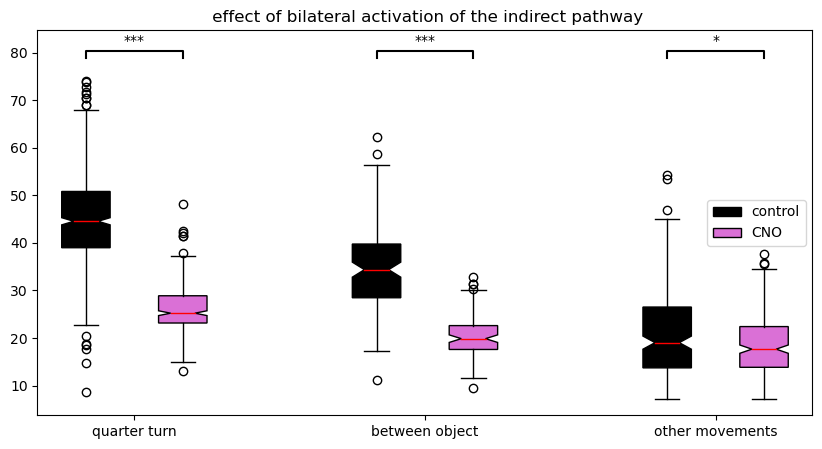

In [9]:
mouseName = "MOU3992" #indicate the name of the mouse for which the graph will be plotted

#select the pertinent informations for the mouse
sessions_to_consider = {"MOU3975" : [["MOU3975_20230313-1145", "MOU3975_20230318-1227"], ["MOU3975_20230315-1209", "MOU3975_20230320-1154"]],
                        "MOU3992" : [["MOU3992_20230313-1213", "MOU3992_20230318-1257"], ["MOU3992_20230315-1239", "MOU3992_20230320-1223"]],
                        "MOU4087" : [["MOU4087_20230629-1626"], ["MOU4087_20230630-1555"]],
                        "MOU4088" : [["MOU4088_20230629-1645"], ["MOU4088_20230630-1613"]]}
pathway  = {"MOU3975" : "direct", "MOU3992" : "indirect", "MOU4087" : "direct", "MOU4088" : "direct"}
activity = {"MOU3975" : "activation", "MOU3992" : "activation", "MOU4087" : "inhibition", "MOU4088" : "inhibtion"}
laterality = {"MOU3975" : "bilateral", "MOU3992" : "bilateral", "MOU4087" : "bilateral", "MOU4088" : "bilateral"}

data_collection = []#data_collection will contain the values of the variables, in the order called by the functions, with each time two list, the first for the control, the second for the test
p_collection = [] #list of the p_values


functions_to_try = [speedMaxDuringQuarterTurnB, medianSpeedDuringBetweenObjectsB, medianSpeedDuringOtherMovementB]
name_variables = ["quarter turn", "between object", "other movements"]

for fun in range(len(functions_to_try)) :#get the datas for the different functions and store them
    variables, p_value = stats_between_two_sessions(fonction_variable = functions_to_try[fun], mouse_name = mouseName, list_session_names = sessions_to_consider[mouseName],
                                metaData= MetaData, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, meta_turn_info= Meta_turn)#getting the datas
    data_collection.append(variables[0])#storing the data
    data_collection.append(variables[1])
    p_collection.append(p_value)#storing the p_value


x_values = []
a = 1
for i in range(len(functions_to_try)):
    x_values = x_values + [a, a+1]#get a position for the control, one for the cno
    a = a + 3 #move the position by three to keep a separation between the conditions

fig = plt.figure(figsize= (10, 5))

infos = plt.boxplot(data_collection, notch = True, positions= x_values, patch_artist= True)

a = 0
color_box = ["k", "orchid"]#the control are in black, the test value in orchid
for box in infos['boxes']:
    box.set_facecolor(color_box[a%2])#a%2 get the rest of the division of a by two. So if it's pair, it's a control, if it's not, it's a test (a start at 0)
    a = a + 1
plt.setp(infos["medians"], color="r")

plt.xticks(ticks = [1, 2], labels= ['Control', 'CNO'])
plt.title(f" effect of {laterality[mouseName]} {activity[mouseName]} of the {pathway[mouseName]} pathway")
plt.legend([infos['boxes'][0], infos['boxes'][1]], ['control', 'CNO'])
bottom, top = plt.ylim()
ranging = top - bottom
base = top + 0.02 * ranging
max_bar = top + 0.04 * ranging

for a  in range(len(p_collection)) : 
    p_value = p_collection[a]
    if p_value < 0.05:

        start = a * 3 + 1#get the coordinate of where the bar showing significativity should be
        end = a * 3 +2
        
        if p_value < 0.001 :#get the number of starts corresponding to the level confidence
            symbol = "***"
        elif p_value < 0.01 : 
            symbol = "**"
        else : 
            symbol = "*"

        plt.plot([start, start, end, end], [base, max_bar, max_bar, base], c= "k")
        plt.text(a * 3 + 1.5, top + 0.05 * ranging, symbol, ha='center', va='bottom', c='k')
plt.ylim(bottom, top + 0.1 * ranging)
plt.xticks([3*a + 1.5 for a in range(len(p_collection))], name_variables)

plt.show()



In [3]:
def howMuchGoodObject(df, session_infos, value_max_proba) : #look 

    limit_time_low = 180
    limit_time_high = 360
    total_duration_before_stop = limit_time_high - limit_time_low

    #creat a list of the passages in a patch. It contains : patch identifier, time of entry, time of leaving, number of turn done in it
    #until the moment where the animal leave the patch is found, it is initialized as the end of the session
    patch_historic = [[whichPatch(patchNumber(df.loc[df.index[0], "xposition"], df.loc[df.index[0], "yposition"], Resolution)), df.loc[df.index[0], "time"], df.loc[df.index[-1], "time"], 0]]
    
    for a in range(1, len(df.index)) : #check when a patch change is done across all frames
        if whichPatch(patchNumber(df.loc[df.index[a], "xposition"], df.loc[df.index[a], "yposition"], Resolution)) != patch_historic[-1][0] : 

            patch_historic[-1][2] = df.loc[df.index[a], "time"]#if the animal leave 
            patch_historic.append([whichPatch(patchNumber(df.loc[df.index[a], "xposition"], df.loc[df.index[a], "yposition"], Resolution)), df.loc[df.index[a], "time"], df.loc[df.index[-1], "time"], 0])


    noProba = True # until proven otherwise, the current session does not have probabilities
    bestPrevious = "" # until we know wich is the 
    if session_infos.loc[session_infos.index[0], "probaNW"] == value_max_proba : #check if one of the object was the right one. If so, note it down
        noProba = False
        bestPrevious = "NW"
    elif session_infos.loc[session_infos.index[0], "probaNE"] == value_max_proba : 
        noProba = False
        bestPrevious = "NE"
    elif session_infos.loc[session_infos.index[0], "probaSE"] == value_max_proba : 
        noProba = False
        bestPrevious = "SE"
    elif session_infos.loc[session_infos.index[0], "probaSW"] == value_max_proba : 
        noProba = False
        bestPrevious = "SW"
    
    if noProba : return 0 

    else :
        corresponding_patch = [patch for patch in patch_historic if patch[0] == bestPrevious]
        times = [patch[2] - patch[1] for patch in corresponding_patch if patch[2] <= limit_time_high and patch[1] >= limit_time_low]#we might be missing a passage which start in the first 3 minutes but end after

        
        a = 0
        size_off_data = len(corresponding_patch)
        while True :#look if there is a passage on the fence. If yes, keep only the relevent part
            if corresponding_patch[a][1] > limit_time_high :
                break
            if corresponding_patch[a][1] < limit_time_low and corresponding_patch[a][2] > limit_time_low:
                times.append(min(corresponding_patch[a][2], limit_time_high) - limit_time_low) #add the relevant part if a passage exceed by the bottom or by both the top and the bottom

            elif corresponding_patch[a][2] > limit_time_high and  corresponding_patch[a][1] < limit_time_high: 
                times.append(limit_time_high - corresponding_patch[a][1]) #add the relevant part if a passage exceed by the top
                break
            
            a = a + 1
            if a >= size_off_data : break
        
        total = sum(times)
        return (total * 100) / total_duration_before_stop

def callHowMuchGoodObject(mouse_name, list_session_names, metaData, meta_session_info) : 

    variable = []
        
    
    length = len(list_session_names)
    for iterateur in range(length) : #loop on each session for each mouse
        session = list_session_names[iterateur]


        start_data = meta_session_info[mouse_name].loc[session, "startPosition"]#get the start and end indice for the session (on the metadata dataframe)
        end_data = meta_session_info[mouse_name].loc[session, "endPosition"]

        variable.append(howMuchGoodObject(metaData.loc[metaData.index[start_data: end_data]], meta_session_info[mouse_name].loc[meta_session_info[mouse_name].index == session], 0.6)) #actual function call

    statistic, p_value = stats.ttest_1samp(variable, 25)
    print(f"t-test on the preference for the spent from 180 to 360s \n statistic = {statistic} \n p_value = {p_value}")

    plt.scatter(np.arange(0, len(variable)), variable )
    plt.axhline( y = 25, xmin= 0, xmax = 1, label = "null hypothesis", c = "r")
    plt.title("percentage of time spent in the most rewarded patch")


    return variable

    # x_values =  np.arange(0, len(variable))
    # statistic, p_value = stats.spearmanr(a = x_values, b =variable)
    # print(f"rank- correlation test on the time spent in the most rewarded object in the first {180}s \n statistic = {statistic} \n p_value = {p_value}")

    # plt.plot(x_values, variable)

    # return statistic, p_value



t-test on the preference for the spent from 180 to 360s 
 statistic = 7.6553686301585575 
 p_value = 9.7716465379637e-07


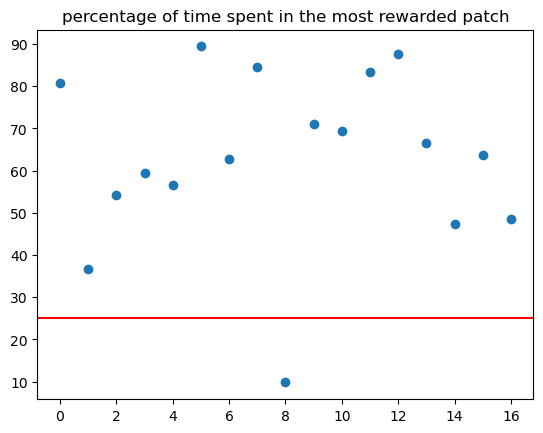

In [4]:
x = callHowMuchGoodObject("MOU4087", sessionFolders["MOU4087"][5:], metaData= MetaData, meta_session_info= Meta_session_infos)


rank- correlation test on number of quarter turn for mouse 0 
 statistic = 0.9118583155200968 
 p_value = 0.0002371436370050654
rank- correlation test on number of quarter turn for mouse 1 
 statistic = 0.8181818181818182 
 p_value = 0.0038149200825507135
rank- correlation test on number of quarter turn for mouse 2 
 statistic = 0.7939393939393938 
 p_value = 0.0060999233136969115
rank- correlation test on number of quarter turn for mouse 3 
 statistic = 0.9757575757575757 
 p_value = 1.4675461874042197e-06
rank- correlation test on number of quarter turn for mouse 4 
 statistic = 0.8909090909090909 
 p_value = 0.0005421442248338665
rank- correlation test on number of quarter turn for the median of the mice 
 statistic = 0.8632258720256917 
 p_value = 0.0012938147605104583


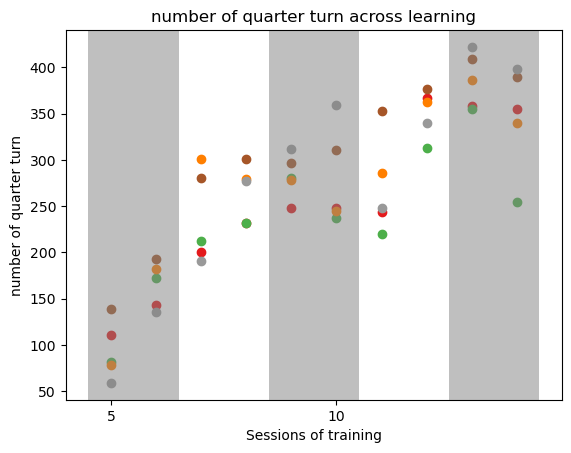

In [2]:
def identity(list_entree): return list_entree[0]

def stats_across_learning(fonction_variable, mouse_name, list_session_names, metaData, meta_list_epoch, meta_session_info, meta_turn_info, variableName = "",
                           treatment_variable = identity, byDay = False, first_session = 2, last_session = -1):
    """
    function which show the statistical difference between both sessions

    fonction_variable : function which take in entry the part of MetaData corresponding to the session then the list_epoch for the session and give back the variable for the session under the form of a list of values
    mouse_name : (string) name of the mouse
    list_session_names : list of list of strings under the format [['name of CNO session 1', 'name of CNO session 2',...], ['name of control session 1', 'name of control session 2', ...]]
    metaData : the dataframe MetaData obtained in the first cell
    meta_list_epoch : the dataframe Meta_list_epoch obtained in the first cell
    meta_session_info : the dictionnary of dataframes Meta_session_info obtained in the first cell
    variableName : (string) the name given of the y axis
    meta_turn_info : Meta_turn
    treatment_variable : eventual function to treat the variable of the day/session. Its output must be a single value, not a list
    byDay : indicate if the results are to be shown by day (True) or by session (False)
    first_session : index of the first session to be analyzed (starting at 0). This code does not support the familiarisation sessions, unless they are the same day
    last_session : index of the first session to NOT be analyzed (starting at 0). enter -1 to get until the last session. Take care, all the mice must jave the same number of sessions
    """

    if last_session == -1 : last_session = len(list_session_names[mouse_name[0]])
    variable = {}
    for mouse in mouse_name : 
        variable[mouse] = []
    if byDay :
            x_values =  list(np.arange(first_session // 2 + 1, last_session // 2 + 1))
    else : 
        x_values = list(np.arange(first_session + 1, last_session + 1))
    rainbow = plt.cm.Set1(np.linspace(0, 1, len(mouse_name))) #creat a a color map with a colo for each mouse

    if not byDay :#will help for the visualization of days
        span = {}
        for souris in mouse_name : span[souris] = []
    
    length = last_session - first_session
    a = 0#is used to know which color to print this mouse in
    for mouse in mouse_name : 
        if not byDay : inaspan = False
        datas = []
        for iterateur in range(first_session, last_session) : #loop on each session for each mouse
            session = list_session_names[mouse][iterateur]
            #meta_session_info[mouse_name].loc[meta_session_info[mouse_name].index == list_session_names[a]]

            if not byDay :
                if meta_session_info[mouse].loc[session, "timeOfDay"] == "M" : #if it is a morning session, change the background
                    if not inaspan : #enter a colored area if it is not in one
                        span[mouse].append([iterateur + 0.5, iterateur + 1.5])
                        inaspan = True
                    else : inaspan = False # signal that it have been 
                elif inaspan :
                    span[mouse][-1] = [span[mouse][-1][0], span[mouse][-1][1] + 1] #if this is an afternoon and the day is on a colored background, increase its withd to contain the session



            start_data = meta_session_info[mouse].loc[session, "startPosition"]#get the start and end indice for the session (on the metadata dataframe)
            end_data = meta_session_info[mouse].loc[session, "endPosition"]
            start_turn = meta_session_info[mouse].loc[session, "startTurns"]
            end_turn = meta_session_info[mouse].loc[session, "endTurns"]
            liste_epoch = [[epoch[0] - start_data, epoch[1] - start_data, epoch[2]] for epoch in meta_list_epoch[mouse][session]] #get the correct indice on the epoch for a reduce dataframe

            resultat = fonction_variable(metaData.loc[metaData.index[start_data: end_data]], liste_epoch, meta_session_info[mouse].loc[meta_session_info[mouse].index == session], meta_turn_info.loc[meta_turn_info.index[start_turn: end_turn]])  #actual function call
            if byDay and meta_session_info[mouse].loc[session, "timeOfDay"] == "A" :
                    datas[-1] = datas[-1] + resultat
            else : #add the result of the session as a seperate list
                datas.append(resultat)

        
        
        variable[mouse] = [treatment_variable(vari) for vari in datas]
        plt.scatter(x_values, variable[mouse], color  = rainbow[a])
        statistic, p_value = stats.spearmanr(a = x_values, b =variable[mouse])
        print(f"rank- correlation test on {variableName} for mouse {a} \n statistic = {statistic} \n p_value = {p_value}")

        a += 1

    new_variable  = [np.median([variable[souris][itemNumber] for souris in mouse_name])  for itemNumber in range(len(x_values)) ]
    statistic, p_value = stats.spearmanr(a = x_values, b =new_variable)
    print(f"rank- correlation test on {variableName} for the median of the mice \n statistic = {statistic} \n p_value = {p_value}")
    # plt.plot(x_values, new_variable , c = "k")

    if not byDay : #creat grey background behind one day out of two
                for i in span[mouse_name[0]] : 
                    plt.axvspan(i[0], i[1], facecolor='grey', alpha=0.5)

    
    plt.title(f"{variableName} across learning")
    plt.ylabel(variableName)
    if not byDay: 
        liste_actuelle = list(np.arange(first_session + 1, last_session, 5))
        plt.xticks(liste_actuelle, liste_actuelle)
        plt.xlabel("Sessions of training")
    else :
        plt.xlabel("Days of training")

    
    return variable, p_value


def speedMaxDuringQuarterTurn(df, list_epoch, session_info, turn_info):
    speeds = [np.max([df.loc[df.index[indice], 'speed']for indice in range(epoch[0], epoch[1] + 1)])  for epoch in list_epoch if epoch[2][0] =="Q"] #get the list of max instantanious speed during epochs
    return speeds 

def numberOfQuarterTurn(df, list_epoch, session_info, turn_info):
    quarters = [1 for epoch in list_epoch if epoch[2][0] == "Q"]
    return [len(quarters)]

def ratioTurnRightDirection(df, list_epoch, session_info, turn_info):
    if session_info.loc[session_info.index[0], "potentialRewardedDirections"] == "[270]" : 
        direction = 270
    elif session_info.loc[session_info.index[0], "potentialRewardedDirections"] == "[90]" :
        direction = 90
    else : direction = 0

    if direction != 0 :
        right_direction = [1 for a in range(len(turn_info)) if turn_info.loc[turn_info.index[a], "time"] <= 120 and turn_info.loc[turn_info.index[a], "turnDirection"] == direction]
        bad_direction = [1 for a in range(len(turn_info)) if turn_info.loc[turn_info.index[a], "time"] <= 120 and turn_info.loc[turn_info.index[a], "turnDirection"] != direction]
        try : 
            return [len(bad_direction)/(len(right_direction) + len(bad_direction))]
        except ZeroDivisionError : 
            return [0]
    else : return [0]

def efficiencyOfTurns(df, list_epoch, session_info, turn_info):
    quartersR = [1 for epoch in list_epoch if epoch[2][0] == "Q" and epoch[2][5] == "R"]#list all the rewarded quarter-turn of the session
    quartersN = [1 for epoch in list_epoch if epoch[2][0] == "Q" and epoch[2][5] != "R"]#list all the non-rewarded quarter-turn of the session
    return[len(quartersR), len(quartersN)]

def ratio_of_components(liste_entree) :
    rewards = sum([liste_entree[x] for x in range(len(liste_entree)) if x%2 == 0])# make the sum of values of pair index in the list (so the rewarded)
    unre = sum([liste_entree[x] for x in range(len(liste_entree)) if x%2 == 1])
    return (rewards - unre)/(rewards + unre)





variable, p_value = stats_across_learning(numberOfQuarterTurn, ["MOU3975", "MOU3987", "MOU3988", "MOU3991", "MOU3992"], sessionFolders, metaData= MetaData, meta_list_epoch= Meta_list_epoch, meta_session_info= Meta_session_infos, meta_turn_info= Meta_turn,
                                          variableName = "number of quarter turn", treatment_variable = np.sum, first_session= 4, last_session= 14, byDay= False)
    

In [7]:
#tests en tout genre
print(np.median(x))
print(stats.normaltest(x))



63.66111111111111
NormaltestResult(statistic=5.0699779181416655, pvalue=0.07926259439259074)


/home/david/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
